![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-907-6.gif)

このノートブックはオライリー・ジャパンより発行の書籍[『セキュリティエンジニアのための機械学習』](https://www.oreilly.co.jp/books/9784873119076/)のサンプルコードです。コードの解説等は書籍をご参照ください。なお、このコードを動作させた結果について、著者およびオライリー・ジャパンは一切の責任を負いません。

##ロジスティック回帰を使用したフィッシング検出器

In [ ]:
!wget https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/dataset.csv

--2021-09-29 12:35:37--  https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/dataset.csv
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/dataset.csv [following]
--2021-09-29 12:35:37--  https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 788720 (770K) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>] 770.23K  --.-KB/s    in 0.05s   

2021-09-29 12:35:38 (13.7 MB/s) - ‘dataset.csv’ saved [788720/788720]



In [ ]:
!pip install optuna

     |████████████████████████████████| 302 kB 2.1 MB/s 
     |████████████████████████████████| 208 kB 22.7 MB/s 
     |████████████████████████████████| 80 kB 7.8 MB/s 
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 144 kB 25.4 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 111 kB 21.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=49c97133fe26ede33aadf8176be69e16e9dec402cb27c8d24742dd7413085314
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

training_data = np.genfromtxt('dataset.csv', delimiter=',', dtype=np.int32)

In [ ]:
X = training_data[:,:-1]
y = training_data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=101)

classifier = LogisticRegression(solver='lbfgs')

# 訓練用データを使って検出器を訓練する。
classifier.fit(X_train, y_train)
# 予測させる。
predictions = classifier.predict(X_test)

# このフィッシング検出器の正解率を出力させる。
accuracy = 100.0 * accuracy_score(y_test, predictions)
print("The accuracy of your Logistic Regression on testing data is: {}".format(accuracy))

The accuracy of your Logistic Regression on testing data is: 92.22071460877432


In [ ]:
from sklearn.model_selection import cross_val_score

# 交差検証(5分割)による汎化性能の評価
scores = cross_val_score(classifier, X_train, y_train, cv=5)
# 評価結果の出力
print("Evaluated score by cross-validation(k=5): {}".format(100 * scores.mean()))

Evaluated score by cross-validation(k=5): 92.88792144243878


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

class Objective:
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # ターゲットのハイパーパラメータの設定
        params = {
            # 最適化に使用するアルゴリズムの候補をカテゴリとして指定
            'solver' : trial.suggest_categorical('solver',\
                    ['newton-cg', 'lbfgs', \
                    'liblinear', 'sag', 'saga']),
            # 正則化の強さに0.0001から10までを指定
            'C': trial.suggest_loguniform('C', 0.0001, 10),
            # ソルバーが収束するまでの最大反復回数
            'max_iter': trial.suggest_int('max_iter', 100, 100000)
            }

        model = LogisticRegression(**params)

        # 評価指標として正解率の最大化を目指す
        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        return scores['test_score'].mean()

# ハイパーパラメータの探索
objective = Objective(X_train, y_train)
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=60)
# ベストのパラメータの出力
print('params:', study.best_params)

[I 2021-09-29 12:35:50,703] A new study created in memory with name: no-name-f28cd533-331d-4b11-8797-ad63e48f6477
[I 2021-09-29 12:35:51,962] Trial 0 finished with value: 0.928087678955567 and parameters: {'solver': 'saga', 'C': 0.021288700280170613, 'max_iter': 84045}. Best is trial 0 with value: 0.928087678955567.
[I 2021-09-29 12:35:52,285] Trial 1 finished with value: 0.9296708138401684 and parameters: {'solver': 'liblinear', 'C': 0.15027268725561385, 'max_iter': 95938}. Best is trial 1 with value: 0.9296708138401684.
[I 2021-09-29 12:35:52,655] Trial 2 finished with value: 0.9297838720651542 and parameters: {'solver': 'sag', 'C': 0.06317430842033597, 'max_iter': 15497}. Best is trial 2 with value: 0.9297838720651542.
[I 2021-09-29 12:35:53,113] Trial 3 finished with value: 0.927974684677541 and parameters: {'solver': 'newton-cg', 'C': 4.165735323805375, 'max_iter': 1669}. Best is trial 2 with value: 0.9297838720651542.
[I 2021-09-29 12:35:53,695] Trial 4 finished with value: 0.929

params: {'solver': 'sag', 'C': 0.09461897507719627, 'max_iter': 27652}


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

model = LogisticRegression(
    # ハイパーパラメータ探索で特定した値を設定
    solver = study.best_params['solver'],
    C = study.best_params['C'],
    max_iter = study.best_params['max_iter']
)

model.fit(X_train, y_train)
pred = model.predict(X_test)
# 正解率の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
# 混同行列の出力
print(confusion_matrix(y_test, pred))

Accuracy: 92.40163 %
[[ 875   96]
 [  72 1168]]


In [ ]:
from sklearn.metrics import precision_score, recall_score

# 適合率の確認
print("Precision: {:.5f} %".format(100 * precision_score(y_test, pred)))
# 再現率の確認
print("Recall: {:.5f} %".format(100 * recall_score(y_test, pred)))

Precision: 92.40506 %
Recall: 94.19355 %


##決定木を使用したフィッシング検出器

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

class Objective_DTC:
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # ターゲットのハイパーパラメータの設定
        params = {
            'criterion':\
            trial.suggest_categorical('criterion', ['gini', 'entropy']),
            'splitter':\
            trial.suggest_categorical('splitter', ['best', 'random']),
            'max_features':\
            trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
            'min_samples_split':\
            trial.suggest_int('min_samples_split', 2, 64),
            'max_depth':\
            trial.suggest_int('max_depth', 2, 64)
            }

        model = DecisionTreeClassifier(**params)

        # 評価指標として正解率の最大化を目指す
        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        return scores['test_score'].mean()

objective = Objective_DTC(X_train, y_train)
study = optuna.create_study(direction='maximize')
# timeoutに60を指定し、最大で1分間探索させる
study.optimize(objective, timeout=60)
print('params:', study.best_params)

[I 2021-09-29 13:13:45,355] A new study created in memory with name: no-name-15d84c41-cca4-43b4-b33a-10c95a628325
[I 2021-09-29 13:13:46,395] Trial 0 finished with value: 0.915651082366242 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_features': 'sqrt', 'min_samples_split': 36, 'max_depth': 27}. Best is trial 0 with value: 0.915651082366242.
[I 2021-09-29 13:13:46,545] Trial 1 finished with value: 0.9147472560359535 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_features': 'auto', 'min_samples_split': 38, 'max_depth': 30}. Best is trial 0 with value: 0.915651082366242.
[I 2021-09-29 13:13:46,693] Trial 2 finished with value: 0.9228866169244583 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'auto', 'min_samples_split': 45, 'max_depth': 11}. Best is trial 2 with value: 0.9228866169244583.
[I 2021-09-29 13:13:46,867] Trial 3 finished with value: 0.9218703078918221 and parameters: {'criterion': 'entropy', 'splitter': 'be

params: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'auto', 'min_samples_split': 2, 'max_depth': 32}


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

model = DecisionTreeClassifier(
    # ハイパーパラメータ探索で特定した値を設定
    criterion = study.best_params['criterion'],
    splitter = study.best_params['splitter'],
    max_features = study.best_params['max_features'],
    min_samples_split = study.best_params['min_samples_split'],
    max_depth = study.best_params['max_depth']
)

model.fit(X_train, y_train)
pred = model.predict(X_test)

# 正解率の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
# 適合率の出力
print("Precision: {:.5f} %".format(100 * precision_score(y_test, pred,)))
# 再現率の出力
print("Recall: {:.5f} %".format(100 * recall_score(y_test, pred)))
# 混同行列の出力
print(confusion_matrix(y_test, pred))

Accuracy: 95.61284 %
Precision: 96.27530 %
Recall: 95.88710 %
[[ 925   46]
 [  51 1189]]


### tf-idfを使った迷惑メール検出

In [ ]:
!wget https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/enron1.zip

--2021-09-29 13:30:35--  https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/enron1.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/enron1.zip [following]
--2021-09-29 13:30:36--  https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/enron1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3597958 (3.4M) [application/zip]
Saving to: ‘enron1.zip’

enron1.zip          100%[===================>]   3.43M  --.-KB/s    in 0.08s   

2021-09-29 13:30:36 (41.2 MB/s) - ‘enron1.zip’ saved [3597958/3597958]



In [ ]:
!unzip -q enron1.zip

In [ ]:
!ls ./enron1/ham

0001.1999-12-10.farmer.ham.txt	2561.2000-10-17.farmer.ham.txt
0002.1999-12-13.farmer.ham.txt	2563.2000-10-17.farmer.ham.txt
0003.1999-12-14.farmer.ham.txt	2564.2000-10-17.farmer.ham.txt
0004.1999-12-14.farmer.ham.txt	2565.2000-10-18.farmer.ham.txt
0005.1999-12-14.farmer.ham.txt	2567.2000-10-18.farmer.ham.txt
0007.1999-12-14.farmer.ham.txt	2569.2000-10-18.farmer.ham.txt
0009.1999-12-14.farmer.ham.txt	2571.2000-10-18.farmer.ham.txt
0010.1999-12-14.farmer.ham.txt	2572.2000-10-18.farmer.ham.txt
0011.1999-12-14.farmer.ham.txt	2573.2000-10-18.farmer.ham.txt
0012.1999-12-14.farmer.ham.txt	2574.2000-10-18.farmer.ham.txt
0013.1999-12-14.farmer.ham.txt	2576.2000-10-18.farmer.ham.txt
0014.1999-12-15.farmer.ham.txt	2577.2000-10-18.farmer.ham.txt
0015.1999-12-15.farmer.ham.txt	2578.2000-10-18.farmer.ham.txt
0016.1999-12-15.farmer.ham.txt	2579.2000-10-18.farmer.ham.txt
0019.1999-12-15.farmer.ham.txt	2582.2000-10-18.farmer.ham.txt
0020.1999-12-15.farmer.ham.txt	2584.2000-10-18.farmer.ham.txt
0021.199

In [ ]:
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate
import os
import codecs

In [ ]:
def init_lists(folder):
    key_list = []
    file_list = os.listdir(folder)
    for filename in file_list:
        f = codecs.open(folder + filename, 'r', encoding='utf-8', errors='ignore')
        key_list.append(f.read())
    f.close()
    return key_list

all_mails = list()
spam = init_lists('./enron1/spam/')
ham = init_lists('./enron1/ham/')
# リストにした迷惑メール(spam)と、通常のメール(ham)を別のリストにコピーし、迷惑メールの場合はラベルを1に、そうでない場合は0にする
all_mails = [(mail, '1') for mail in spam]
all_mails += [(mail, '0') for mail in ham]

In [ ]:
import pandas as pd
# DataFrameにメールの文面とラベルを列に設定してロードする
df = pd.DataFrame(all_mails, columns=['text', 'label'])

In [ ]:
df

,text,label
0,Subject: fwd :\r\nyour needed soffttwares at r...,1
1,Subject: hi paliourg all available meds . avai...,1
2,Subject: today is a day to remember\r\ncongrad...,1
3,Subject: how to earn thousands writing google ...,1
4,Subject: test & keep an ibm laptop - product t...,1
...,...,...
5167,Subject: fw : txu lone star pipeline standard ...,0
5168,Subject: revised : eastrans nomination change ...,0
5169,Subject: re : hpl transport contracts\r\nthank...,0
5170,Subject: re : meter 5892\r\ndaren :\r\nsorry i...,0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizerを初期化する。stop_wordsにenglishを指定し、一般的な単語を除外する
tfidf = TfidfVectorizer(stop_words="english", lowercase=False)

X = tfidf.fit_transform(df['text'])
column_names = tfidf.get_feature_names()

# Xにベクトル化した値を整形して代入
X = pd.DataFrame(X.toarray())
X = X.astype('float')
# カラム名を設定
X.columns = column_names
y = df['label'].astype('float')

In [ ]:
X

,00,000,0000,000000,000000000002858,000000000049773,000080,000099,0001,00018,00020608,0004,0005,0008,001,0010,001001,0012,001452,002,0022,00221,0025,0027,0028,0029,00298,003,0030,003002,0031,0033,0038,004,0042,0043,0044,0045,0046,0047,...,zv,zve,zvikydqu,zvjc,zvp,zvrkxjmex,zvx,zw,zwallet,zwdm,zwftnqlp,zwiers,zwmdjvr,zwoegen,zwu,zxaghur,zxgwvpiadobe,zxgwvpihere,zxgwvpiimg,zxgwvpimacromedia,zxgwvpimicrosoft,zxgwvpinorton,zxjcxz,zxklh,zxzmcnbf,zyban,zyjvit,zykfe,zyl,zynsdirnh,zynve,zyqtaqlt,zyrtec,zyyqywp,zzezrjok,zzn,zzo,zzocb,zzso,zzsyt
0,0.511833,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.180055,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5168,0.049459,0.015846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5169,0.000000,0.023266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5170,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as olgb
import optuna

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test =\
 train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# LightGBM用のデータセットに変換
train = olgb.Dataset(X_train, y_train)

# パラメータの設定
params = {
    "objective": "binary",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

# 交差検証を使用したハイパーパラメータの探索
tuner = olgb.LightGBMTunerCV(params, train, num_boost_round=100)

# ハイパーパラメータ探索の実行
tuner.run()

[I 2021-09-29 13:31:05,923] A new study created in memory with name: no-name-1888bf13-7620-41d7-8d7a-d2eb64871edf
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.535028 + 0.00169789
[2]	cv_agg's binary_logloss: 0.479874 + 0.00269972
[3]	cv_agg's binary_logloss: 0.435612 + 0.00354558
[4]	cv_agg's binary_logloss: 0.39791 + 0.00492017
[5]	cv_agg's binary_logloss: 0.364699 + 0.00616565
[6]	cv_agg's binary_logloss: 0.338165 + 0.00683242
[7]	cv_agg's binary_logloss: 0.314289 + 0.00678365
[8]	cv_agg's binary_logloss: 0.293845 + 0.0067166
[9]	cv_agg's binary_logloss: 0.275317 + 0.00790597
[10]	cv_agg's binary_logloss: 0.2597 + 0.00849883
[11]	cv_agg's binary_logloss: 0.245538 + 0.00870488
[12]	cv_agg's binary_logloss: 0.232256 + 0.00897539
[13]	cv_agg's binary_logloss: 0.219943 + 0.0095902
[14]	cv_agg's binary_logloss: 0.208244 + 0.010265
[15]	cv_agg's binary_logloss: 0.199578 + 0.0106964
[16]	cv_agg's binary_logloss: 0.189784 + 0.0109229
[17]	cv_agg's binary_logloss: 0.18161 + 0.0105257
[18]	cv_agg's binary_logloss: 0.174059 + 0.0106261
[19]	cv_agg's binary_logloss: 0.166835 + 0.0108669
[20]	cv_agg's binary_logloss: 0.16

feature_fraction, val_score: 0.065470:  14%|#4        | 1/7 [00:21<02:11, 21.89s/it]

[100]	cv_agg's binary_logloss: 0.0654697 + 0.0155229
[1]	cv_agg's binary_logloss: 0.536154 + 0.001489
[2]	cv_agg's binary_logloss: 0.480151 + 0.00344562
[3]	cv_agg's binary_logloss: 0.436344 + 0.00408879
[4]	cv_agg's binary_logloss: 0.39932 + 0.00547563
[5]	cv_agg's binary_logloss: 0.366728 + 0.00673203
[6]	cv_agg's binary_logloss: 0.340137 + 0.0073248
[7]	cv_agg's binary_logloss: 0.316849 + 0.00757263
[8]	cv_agg's binary_logloss: 0.296683 + 0.00789833
[9]	cv_agg's binary_logloss: 0.278608 + 0.00864229
[10]	cv_agg's binary_logloss: 0.262675 + 0.00916533
[11]	cv_agg's binary_logloss: 0.247719 + 0.00940732
[12]	cv_agg's binary_logloss: 0.233524 + 0.00996488
[13]	cv_agg's binary_logloss: 0.221557 + 0.0102884
[14]	cv_agg's binary_logloss: 0.210108 + 0.0107
[15]	cv_agg's binary_logloss: 0.201273 + 0.0111183
[16]	cv_agg's binary_logloss: 0.191339 + 0.010996
[17]	cv_agg's binary_logloss: 0.183108 + 0.0108332
[18]	cv_agg's binary_logloss: 0.175524 + 0.0112174
[19]	cv_agg's binary_logloss: 0.16

feature_fraction, val_score: 0.064544:  29%|##8       | 2/7 [00:42<01:46, 21.22s/it]

[1]	cv_agg's binary_logloss: 0.533127 + 0.000697003
[2]	cv_agg's binary_logloss: 0.477917 + 0.00205148
[3]	cv_agg's binary_logloss: 0.433606 + 0.00401048
[4]	cv_agg's binary_logloss: 0.396419 + 0.00511188
[5]	cv_agg's binary_logloss: 0.364257 + 0.00604587
[6]	cv_agg's binary_logloss: 0.336047 + 0.00662883
[7]	cv_agg's binary_logloss: 0.31211 + 0.00754593
[8]	cv_agg's binary_logloss: 0.29104 + 0.00733666
[9]	cv_agg's binary_logloss: 0.272529 + 0.00832019
[10]	cv_agg's binary_logloss: 0.257026 + 0.0088061
[11]	cv_agg's binary_logloss: 0.242284 + 0.00923816
[12]	cv_agg's binary_logloss: 0.22878 + 0.00954208
[13]	cv_agg's binary_logloss: 0.216452 + 0.0103552
[14]	cv_agg's binary_logloss: 0.205169 + 0.010381
[15]	cv_agg's binary_logloss: 0.195204 + 0.010724
[16]	cv_agg's binary_logloss: 0.186199 + 0.0108447
[17]	cv_agg's binary_logloss: 0.17808 + 0.0112073
[18]	cv_agg's binary_logloss: 0.170306 + 0.0110174
[19]	cv_agg's binary_logloss: 0.163158 + 0.0109926
[20]	cv_agg's binary_logloss: 0.15

feature_fraction, val_score: 0.064544:  43%|####2     | 3/7 [01:05<01:27, 21.85s/it]

[100]	cv_agg's binary_logloss: 0.0676492 + 0.0147154
[1]	cv_agg's binary_logloss: 0.542271 + 0.00150823
[2]	cv_agg's binary_logloss: 0.491008 + 0.00201933
[3]	cv_agg's binary_logloss: 0.447031 + 0.00233812
[4]	cv_agg's binary_logloss: 0.410131 + 0.00386086
[5]	cv_agg's binary_logloss: 0.376296 + 0.00574908
[6]	cv_agg's binary_logloss: 0.35033 + 0.00596958
[7]	cv_agg's binary_logloss: 0.328414 + 0.00688698
[8]	cv_agg's binary_logloss: 0.307414 + 0.00726555
[9]	cv_agg's binary_logloss: 0.289631 + 0.00783774
[10]	cv_agg's binary_logloss: 0.273122 + 0.00850863
[11]	cv_agg's binary_logloss: 0.258527 + 0.00897216
[12]	cv_agg's binary_logloss: 0.245351 + 0.00921067
[13]	cv_agg's binary_logloss: 0.232774 + 0.0089114
[14]	cv_agg's binary_logloss: 0.220369 + 0.0093616
[15]	cv_agg's binary_logloss: 0.211353 + 0.00928715
[16]	cv_agg's binary_logloss: 0.201548 + 0.00945156
[17]	cv_agg's binary_logloss: 0.192755 + 0.00958847
[18]	cv_agg's binary_logloss: 0.183601 + 0.00955085
[19]	cv_agg's binary_lo

feature_fraction, val_score: 0.063167:  57%|#####7    | 4/7 [01:21<00:59, 19.79s/it]

[99]	cv_agg's binary_logloss: 0.0632779 + 0.0137557
[100]	cv_agg's binary_logloss: 0.063167 + 0.0137033
[1]	cv_agg's binary_logloss: 0.542203 + 0.00174555
[2]	cv_agg's binary_logloss: 0.492018 + 0.0035227
[3]	cv_agg's binary_logloss: 0.450866 + 0.00402516
[4]	cv_agg's binary_logloss: 0.415304 + 0.00622008
[5]	cv_agg's binary_logloss: 0.38204 + 0.00782388
[6]	cv_agg's binary_logloss: 0.35602 + 0.00817269
[7]	cv_agg's binary_logloss: 0.335031 + 0.00866023
[8]	cv_agg's binary_logloss: 0.31314 + 0.00907942
[9]	cv_agg's binary_logloss: 0.295975 + 0.00929432
[10]	cv_agg's binary_logloss: 0.278162 + 0.00944999
[11]	cv_agg's binary_logloss: 0.262694 + 0.00959137
[12]	cv_agg's binary_logloss: 0.24986 + 0.00968009
[13]	cv_agg's binary_logloss: 0.236196 + 0.00971307
[14]	cv_agg's binary_logloss: 0.224001 + 0.00977313
[15]	cv_agg's binary_logloss: 0.21445 + 0.00987706
[16]	cv_agg's binary_logloss: 0.204538 + 0.010105
[17]	cv_agg's binary_logloss: 0.194376 + 0.00999228
[18]	cv_agg's binary_logloss:

feature_fraction, val_score: 0.061014:  71%|#######1  | 5/7 [01:37<00:36, 18.14s/it]

[1]	cv_agg's binary_logloss: 0.538174 + 0.00145571
[2]	cv_agg's binary_logloss: 0.483355 + 0.00187751
[3]	cv_agg's binary_logloss: 0.440779 + 0.00350217
[4]	cv_agg's binary_logloss: 0.403568 + 0.00492914
[5]	cv_agg's binary_logloss: 0.370768 + 0.006252
[6]	cv_agg's binary_logloss: 0.343653 + 0.00668245
[7]	cv_agg's binary_logloss: 0.321298 + 0.00680397
[8]	cv_agg's binary_logloss: 0.301388 + 0.00714767
[9]	cv_agg's binary_logloss: 0.283031 + 0.00757475
[10]	cv_agg's binary_logloss: 0.267168 + 0.0082433
[11]	cv_agg's binary_logloss: 0.252697 + 0.00926016
[12]	cv_agg's binary_logloss: 0.239449 + 0.0100024
[13]	cv_agg's binary_logloss: 0.226327 + 0.00988742
[14]	cv_agg's binary_logloss: 0.214152 + 0.0100912
[15]	cv_agg's binary_logloss: 0.204948 + 0.01002
[16]	cv_agg's binary_logloss: 0.194803 + 0.0102624
[17]	cv_agg's binary_logloss: 0.186651 + 0.0106147
[18]	cv_agg's binary_logloss: 0.178504 + 0.0105699
[19]	cv_agg's binary_logloss: 0.171358 + 0.0107312
[20]	cv_agg's binary_logloss: 0.1

feature_fraction, val_score: 0.061014:  86%|########5 | 6/7 [01:55<00:18, 18.09s/it]

[1]	cv_agg's binary_logloss: 0.533142 + 0.000626312
[2]	cv_agg's binary_logloss: 0.478467 + 0.00191088
[3]	cv_agg's binary_logloss: 0.434029 + 0.0032442
[4]	cv_agg's binary_logloss: 0.395724 + 0.00421227
[5]	cv_agg's binary_logloss: 0.363728 + 0.00529739
[6]	cv_agg's binary_logloss: 0.336764 + 0.00620132
[7]	cv_agg's binary_logloss: 0.312826 + 0.00687409
[8]	cv_agg's binary_logloss: 0.291994 + 0.00699656
[9]	cv_agg's binary_logloss: 0.272998 + 0.00739394
[10]	cv_agg's binary_logloss: 0.256798 + 0.00798225
[11]	cv_agg's binary_logloss: 0.241944 + 0.00889646
[12]	cv_agg's binary_logloss: 0.228571 + 0.00862625
[13]	cv_agg's binary_logloss: 0.216248 + 0.00869241
[14]	cv_agg's binary_logloss: 0.205013 + 0.00887384
[15]	cv_agg's binary_logloss: 0.195877 + 0.00915994
[16]	cv_agg's binary_logloss: 0.186165 + 0.0091825
[17]	cv_agg's binary_logloss: 0.178194 + 0.0097543
[18]	cv_agg's binary_logloss: 0.171538 + 0.00975187
[19]	cv_agg's binary_logloss: 0.164532 + 0.010054
[20]	cv_agg's binary_logl

num_leaves, val_score: 0.061014:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382225
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582206
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815209
[6]	cv_agg's binary_logloss: 0.35453 + 0.00833844
[7]	cv_agg's binary_logloss: 0.333392 + 0.0088192
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932023
[9]	cv_agg's binary_logloss: 0.294496 + 0.00969055
[10]	cv_agg's binary_logloss: 0.276283 + 0.00972485
[11]	cv_agg's binary_logloss: 0.260371 + 0.0101333
[12]	cv_agg's binary_logloss: 0.246937 + 0.00977777
[13]	cv_agg's binary_logloss: 0.232973 + 0.0100134
[14]	cv_agg's binary_logloss: 0.22083 + 0.0101619
[15]	cv_agg's binary_logloss: 0.210987 + 0.0100588
[16]	cv_agg's binary_logloss: 0.200997 + 0.0100391
[17]	cv_agg's binary_logloss: 0.191029 + 0.0100302
[18]	cv_agg's binary_logloss: 0.182128 + 0.0102408
[19]	cv_agg's binary_logloss: 0.175256 + 0.0104291
[20]	cv_agg's binary_logloss: 0.1

num_leaves, val_score: 0.061014:   5%|5         | 1/20 [00:23<07:29, 23.67s/it]

[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450337 + 0.00382194
[4]	cv_agg's binary_logloss: 0.414503 + 0.0058217
[5]	cv_agg's binary_logloss: 0.381228 + 0.00815166
[6]	cv_agg's binary_logloss: 0.35453 + 0.00833788
[7]	cv_agg's binary_logloss: 0.333394 + 0.00881838
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932041
[9]	cv_agg's binary_logloss: 0.294493 + 0.00968711
[10]	cv_agg's binary_logloss: 0.27628 + 0.00971936
[11]	cv_agg's binary_logloss: 0.260374 + 0.0101347
[12]	cv_agg's binary_logloss: 0.24694 + 0.00977909
[13]	cv_agg's binary_logloss: 0.232975 + 0.0100146
[14]	cv_agg's binary_logloss: 0.220834 + 0.0101593
[15]	cv_agg's binary_logloss: 0.210988 + 0.0100573
[16]	cv_agg's binary_logloss: 0.201008 + 0.0100204
[17]	cv_agg's binary_logloss: 0.191035 + 0.0100147
[18]	cv_agg's binary_logloss: 0.182138 + 0.010285
[19]	cv_agg's binary_logloss: 0.175204 + 0.0106329
[20]	cv_agg's binary_logloss: 0.167

num_leaves, val_score: 0.061014:  10%|#         | 2/20 [00:46<06:53, 22.96s/it]

[100]	cv_agg's binary_logloss: 0.0626032 + 0.0142319
[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382225
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582206
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815209
[6]	cv_agg's binary_logloss: 0.35453 + 0.00833844
[7]	cv_agg's binary_logloss: 0.333392 + 0.0088192
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932023
[9]	cv_agg's binary_logloss: 0.294496 + 0.00969055
[10]	cv_agg's binary_logloss: 0.276283 + 0.00972485
[11]	cv_agg's binary_logloss: 0.260371 + 0.0101333
[12]	cv_agg's binary_logloss: 0.246937 + 0.00977777
[13]	cv_agg's binary_logloss: 0.232973 + 0.0100134
[14]	cv_agg's binary_logloss: 0.22083 + 0.0101619
[15]	cv_agg's binary_logloss: 0.210987 + 0.0100588
[16]	cv_agg's binary_logloss: 0.200997 + 0.0100391
[17]	cv_agg's binary_logloss: 0.191029 + 0.0100302
[18]	cv_agg's binary_logloss: 0.182128 + 0.0102408
[19]	cv_agg's binary_logloss: 0

num_leaves, val_score: 0.061014:  15%|#5        | 3/20 [01:09<06:36, 23.30s/it]

[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382225
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582206
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815209
[6]	cv_agg's binary_logloss: 0.35453 + 0.00833844
[7]	cv_agg's binary_logloss: 0.333392 + 0.0088192
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932023
[9]	cv_agg's binary_logloss: 0.294496 + 0.00969055
[10]	cv_agg's binary_logloss: 0.276283 + 0.00972485
[11]	cv_agg's binary_logloss: 0.260371 + 0.0101333
[12]	cv_agg's binary_logloss: 0.246937 + 0.00977777
[13]	cv_agg's binary_logloss: 0.232973 + 0.0100134
[14]	cv_agg's binary_logloss: 0.22083 + 0.0101619
[15]	cv_agg's binary_logloss: 0.210987 + 0.0100588
[16]	cv_agg's binary_logloss: 0.200997 + 0.0100391
[17]	cv_agg's binary_logloss: 0.191029 + 0.0100302
[18]	cv_agg's binary_logloss: 0.182128 + 0.0102408
[19]	cv_agg's binary_logloss: 0.175256 + 0.0104291
[20]	cv_agg's binary_logloss: 0.1

num_leaves, val_score: 0.061014:  20%|##        | 4/20 [01:34<06:18, 23.66s/it]

[1]	cv_agg's binary_logloss: 0.543128 + 0.001454
[2]	cv_agg's binary_logloss: 0.493439 + 0.00326135
[3]	cv_agg's binary_logloss: 0.452039 + 0.00390524
[4]	cv_agg's binary_logloss: 0.41679 + 0.00567089
[5]	cv_agg's binary_logloss: 0.383066 + 0.00677337
[6]	cv_agg's binary_logloss: 0.357596 + 0.0072958
[7]	cv_agg's binary_logloss: 0.336627 + 0.00768948
[8]	cv_agg's binary_logloss: 0.314482 + 0.00811504
[9]	cv_agg's binary_logloss: 0.297547 + 0.00861009
[10]	cv_agg's binary_logloss: 0.280029 + 0.00900701
[11]	cv_agg's binary_logloss: 0.264405 + 0.00937076
[12]	cv_agg's binary_logloss: 0.251915 + 0.00939711
[13]	cv_agg's binary_logloss: 0.238262 + 0.00938698
[14]	cv_agg's binary_logloss: 0.226481 + 0.00954299
[15]	cv_agg's binary_logloss: 0.216751 + 0.00970086
[16]	cv_agg's binary_logloss: 0.206785 + 0.00993611
[17]	cv_agg's binary_logloss: 0.196877 + 0.0101388
[18]	cv_agg's binary_logloss: 0.188048 + 0.0106584
[19]	cv_agg's binary_logloss: 0.181245 + 0.0105357
[20]	cv_agg's binary_logloss

num_leaves, val_score: 0.061014:  25%|##5       | 5/20 [01:48<05:05, 20.35s/it]

[100]	cv_agg's binary_logloss: 0.0616236 + 0.0140202
[1]	cv_agg's binary_logloss: 0.541962 + 0.00180384
[2]	cv_agg's binary_logloss: 0.491818 + 0.00321638
[3]	cv_agg's binary_logloss: 0.450371 + 0.00384403
[4]	cv_agg's binary_logloss: 0.414597 + 0.00583652
[5]	cv_agg's binary_logloss: 0.380997 + 0.00803179
[6]	cv_agg's binary_logloss: 0.35429 + 0.00824566
[7]	cv_agg's binary_logloss: 0.333026 + 0.00865064
[8]	cv_agg's binary_logloss: 0.311369 + 0.00912932
[9]	cv_agg's binary_logloss: 0.293998 + 0.00940326
[10]	cv_agg's binary_logloss: 0.275979 + 0.00956704
[11]	cv_agg's binary_logloss: 0.260103 + 0.00978542
[12]	cv_agg's binary_logloss: 0.246666 + 0.00946867
[13]	cv_agg's binary_logloss: 0.232862 + 0.00976888
[14]	cv_agg's binary_logloss: 0.22083 + 0.00991503
[15]	cv_agg's binary_logloss: 0.211171 + 0.0100674
[16]	cv_agg's binary_logloss: 0.201279 + 0.0101866
[17]	cv_agg's binary_logloss: 0.191242 + 0.0101684
[18]	cv_agg's binary_logloss: 0.182246 + 0.010371
[19]	cv_agg's binary_loglos

num_leaves, val_score: 0.061014:  30%|###       | 6/20 [02:06<04:34, 19.64s/it]

[100]	cv_agg's binary_logloss: 0.0638404 + 0.0144762
[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382226
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582206
[5]	cv_agg's binary_logloss: 0.381227 + 0.0081521
[6]	cv_agg's binary_logloss: 0.35453 + 0.00833844
[7]	cv_agg's binary_logloss: 0.333392 + 0.0088192
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932021
[9]	cv_agg's binary_logloss: 0.294496 + 0.00969053
[10]	cv_agg's binary_logloss: 0.276283 + 0.0097247
[11]	cv_agg's binary_logloss: 0.260371 + 0.0101331
[12]	cv_agg's binary_logloss: 0.246937 + 0.00977765
[13]	cv_agg's binary_logloss: 0.232972 + 0.0100133
[14]	cv_agg's binary_logloss: 0.22083 + 0.0101618
[15]	cv_agg's binary_logloss: 0.210986 + 0.0100586
[16]	cv_agg's binary_logloss: 0.200997 + 0.0100389
[17]	cv_agg's binary_logloss: 0.191029 + 0.0100301
[18]	cv_agg's binary_logloss: 0.182128 + 0.0102407
[19]	cv_agg's binary_logloss: 0.1

num_leaves, val_score: 0.061014:  35%|###5      | 7/20 [02:31<04:35, 21.18s/it]

[100]	cv_agg's binary_logloss: 0.0616223 + 0.0140266
[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491768 + 0.00321244
[3]	cv_agg's binary_logloss: 0.450406 + 0.00388612
[4]	cv_agg's binary_logloss: 0.41461 + 0.0059329
[5]	cv_agg's binary_logloss: 0.381076 + 0.00820363
[6]	cv_agg's binary_logloss: 0.354281 + 0.0083955
[7]	cv_agg's binary_logloss: 0.332985 + 0.00867422
[8]	cv_agg's binary_logloss: 0.311405 + 0.0091978
[9]	cv_agg's binary_logloss: 0.294198 + 0.00955696
[10]	cv_agg's binary_logloss: 0.276149 + 0.00963006
[11]	cv_agg's binary_logloss: 0.26029 + 0.00985495
[12]	cv_agg's binary_logloss: 0.246876 + 0.0095093
[13]	cv_agg's binary_logloss: 0.233017 + 0.00955209
[14]	cv_agg's binary_logloss: 0.220857 + 0.00966135
[15]	cv_agg's binary_logloss: 0.211166 + 0.00967329
[16]	cv_agg's binary_logloss: 0.201348 + 0.00974101
[17]	cv_agg's binary_logloss: 0.19131 + 0.0097063
[18]	cv_agg's binary_logloss: 0.182381 + 0.00976834
[19]	cv_agg's binary_logloss:

num_leaves, val_score: 0.061014:  40%|####      | 8/20 [02:50<04:07, 20.60s/it]

[100]	cv_agg's binary_logloss: 0.0626593 + 0.0153604
[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382225
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582206
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815209
[6]	cv_agg's binary_logloss: 0.35453 + 0.00833844
[7]	cv_agg's binary_logloss: 0.333392 + 0.0088192
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932023
[9]	cv_agg's binary_logloss: 0.294496 + 0.00969055
[10]	cv_agg's binary_logloss: 0.276283 + 0.00972485
[11]	cv_agg's binary_logloss: 0.260371 + 0.0101333
[12]	cv_agg's binary_logloss: 0.246937 + 0.00977777
[13]	cv_agg's binary_logloss: 0.232973 + 0.0100134
[14]	cv_agg's binary_logloss: 0.22083 + 0.0101619
[15]	cv_agg's binary_logloss: 0.210987 + 0.0100588
[16]	cv_agg's binary_logloss: 0.200997 + 0.0100391
[17]	cv_agg's binary_logloss: 0.191029 + 0.0100302
[18]	cv_agg's binary_logloss: 0.182128 + 0.0102408
[19]	cv_agg's binary_logloss: 0

num_leaves, val_score: 0.061014:  45%|####5     | 9/20 [03:14<03:58, 21.66s/it]

[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382282
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582256
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815254
[6]	cv_agg's binary_logloss: 0.354529 + 0.00833882
[7]	cv_agg's binary_logloss: 0.333392 + 0.00881959
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932108
[9]	cv_agg's binary_logloss: 0.294495 + 0.00969129
[10]	cv_agg's binary_logloss: 0.276282 + 0.00972548
[11]	cv_agg's binary_logloss: 0.26037 + 0.0101337
[12]	cv_agg's binary_logloss: 0.246936 + 0.00977817
[13]	cv_agg's binary_logloss: 0.232972 + 0.0100138
[14]	cv_agg's binary_logloss: 0.220829 + 0.0101623
[15]	cv_agg's binary_logloss: 0.210986 + 0.0100588
[16]	cv_agg's binary_logloss: 0.200997 + 0.0100391
[17]	cv_agg's binary_logloss: 0.191028 + 0.0100302
[18]	cv_agg's binary_logloss: 0.182128 + 0.0102408
[19]	cv_agg's binary_logloss: 0.175256 + 0.0104291
[20]	cv_agg's binary_logloss: 0

num_leaves, val_score: 0.060959:  50%|#####     | 10/20 [03:37<03:40, 22.10s/it]

[100]	cv_agg's binary_logloss: 0.0609592 + 0.0137376
[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382225
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582206
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815209
[6]	cv_agg's binary_logloss: 0.35453 + 0.00833844
[7]	cv_agg's binary_logloss: 0.333392 + 0.0088192
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932023
[9]	cv_agg's binary_logloss: 0.294496 + 0.00969055
[10]	cv_agg's binary_logloss: 0.276283 + 0.00972485
[11]	cv_agg's binary_logloss: 0.260371 + 0.0101333
[12]	cv_agg's binary_logloss: 0.246937 + 0.00977777
[13]	cv_agg's binary_logloss: 0.232973 + 0.0100134
[14]	cv_agg's binary_logloss: 0.22083 + 0.0101619
[15]	cv_agg's binary_logloss: 0.210987 + 0.0100588
[16]	cv_agg's binary_logloss: 0.200997 + 0.0100391
[17]	cv_agg's binary_logloss: 0.191029 + 0.0100302
[18]	cv_agg's binary_logloss: 0.182128 + 0.0102408
[19]	cv_agg's binary_logloss: 0

num_leaves, val_score: 0.060959:  55%|#####5    | 11/20 [04:01<03:23, 22.60s/it]

[100]	cv_agg's binary_logloss: 0.0621711 + 0.0134873
[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382225
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582206
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815209
[6]	cv_agg's binary_logloss: 0.35453 + 0.00833844
[7]	cv_agg's binary_logloss: 0.333392 + 0.0088192
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932023
[9]	cv_agg's binary_logloss: 0.294496 + 0.00969055
[10]	cv_agg's binary_logloss: 0.276283 + 0.00972485
[11]	cv_agg's binary_logloss: 0.260371 + 0.0101333
[12]	cv_agg's binary_logloss: 0.246937 + 0.00977777
[13]	cv_agg's binary_logloss: 0.232973 + 0.0100134
[14]	cv_agg's binary_logloss: 0.22083 + 0.0101619
[15]	cv_agg's binary_logloss: 0.210987 + 0.0100588
[16]	cv_agg's binary_logloss: 0.200997 + 0.0100391
[17]	cv_agg's binary_logloss: 0.191029 + 0.0100302
[18]	cv_agg's binary_logloss: 0.182128 + 0.0102408
[19]	cv_agg's binary_logloss: 0

num_leaves, val_score: 0.060959:  60%|######    | 12/20 [04:25<03:04, 23.11s/it]

[100]	cv_agg's binary_logloss: 0.0621711 + 0.0134873
[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382301
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582275
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815272
[6]	cv_agg's binary_logloss: 0.354529 + 0.00833901
[7]	cv_agg's binary_logloss: 0.333392 + 0.00881974
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932134
[9]	cv_agg's binary_logloss: 0.294496 + 0.00969151
[10]	cv_agg's binary_logloss: 0.276282 + 0.00972552
[11]	cv_agg's binary_logloss: 0.260377 + 0.0101404
[12]	cv_agg's binary_logloss: 0.246942 + 0.00978389
[13]	cv_agg's binary_logloss: 0.232977 + 0.0100186
[14]	cv_agg's binary_logloss: 0.220834 + 0.0101663
[15]	cv_agg's binary_logloss: 0.210983 + 0.0100787
[16]	cv_agg's binary_logloss: 0.200938 + 0.0101652
[17]	cv_agg's binary_logloss: 0.190967 + 0.0101592
[18]	cv_agg's binary_logloss: 0.182021 + 0.0104566
[19]	cv_agg's binary_logloss

num_leaves, val_score: 0.060835:  65%|######5   | 13/20 [04:49<02:42, 23.22s/it]

[100]	cv_agg's binary_logloss: 0.0608353 + 0.0141149
[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382271
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582246
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815243
[6]	cv_agg's binary_logloss: 0.354529 + 0.00833876
[7]	cv_agg's binary_logloss: 0.333392 + 0.00881955
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932102
[9]	cv_agg's binary_logloss: 0.294496 + 0.0096912
[10]	cv_agg's binary_logloss: 0.276282 + 0.00972534
[11]	cv_agg's binary_logloss: 0.260377 + 0.0101405
[12]	cv_agg's binary_logloss: 0.246942 + 0.00978399
[13]	cv_agg's binary_logloss: 0.232977 + 0.0100186
[14]	cv_agg's binary_logloss: 0.220834 + 0.0101663
[15]	cv_agg's binary_logloss: 0.210991 + 0.010063
[16]	cv_agg's binary_logloss: 0.201002 + 0.0100434
[17]	cv_agg's binary_logloss: 0.191033 + 0.0100342
[18]	cv_agg's binary_logloss: 0.182132 + 0.0102443
[19]	cv_agg's binary_logloss: 

num_leaves, val_score: 0.060835:  70%|#######   | 14/20 [05:12<02:19, 23.31s/it]

[100]	cv_agg's binary_logloss: 0.0614312 + 0.0133159
[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382225
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582206
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815209
[6]	cv_agg's binary_logloss: 0.35453 + 0.00833844
[7]	cv_agg's binary_logloss: 0.333392 + 0.0088192
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932023
[9]	cv_agg's binary_logloss: 0.294496 + 0.00969055
[10]	cv_agg's binary_logloss: 0.276283 + 0.00972485
[11]	cv_agg's binary_logloss: 0.260371 + 0.0101333
[12]	cv_agg's binary_logloss: 0.246937 + 0.00977777
[13]	cv_agg's binary_logloss: 0.232973 + 0.0100134
[14]	cv_agg's binary_logloss: 0.22083 + 0.0101619
[15]	cv_agg's binary_logloss: 0.210987 + 0.0100588
[16]	cv_agg's binary_logloss: 0.200997 + 0.0100391
[17]	cv_agg's binary_logloss: 0.191029 + 0.0100302
[18]	cv_agg's binary_logloss: 0.182128 + 0.0102408
[19]	cv_agg's binary_logloss: 0

num_leaves, val_score: 0.060835:  75%|#######5  | 15/20 [05:36<01:58, 23.61s/it]

[100]	cv_agg's binary_logloss: 0.0621711 + 0.0134873
[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00321796
[3]	cv_agg's binary_logloss: 0.450338 + 0.00382086
[4]	cv_agg's binary_logloss: 0.414505 + 0.00581724
[5]	cv_agg's binary_logloss: 0.381368 + 0.00811427
[6]	cv_agg's binary_logloss: 0.354693 + 0.00829058
[7]	cv_agg's binary_logloss: 0.333554 + 0.00878129
[8]	cv_agg's binary_logloss: 0.311914 + 0.00930259
[9]	cv_agg's binary_logloss: 0.294629 + 0.00967771
[10]	cv_agg's binary_logloss: 0.276415 + 0.00971136
[11]	cv_agg's binary_logloss: 0.260461 + 0.0100751
[12]	cv_agg's binary_logloss: 0.247019 + 0.00973829
[13]	cv_agg's binary_logloss: 0.233226 + 0.00964673
[14]	cv_agg's binary_logloss: 0.221102 + 0.00985024
[15]	cv_agg's binary_logloss: 0.211346 + 0.0097647
[16]	cv_agg's binary_logloss: 0.201422 + 0.00982129
[17]	cv_agg's binary_logloss: 0.191377 + 0.00995602
[18]	cv_agg's binary_logloss: 0.18258 + 0.0103283
[19]	cv_agg's binary_logl

num_leaves, val_score: 0.060835:  80%|########  | 16/20 [05:57<01:30, 22.73s/it]

[100]	cv_agg's binary_logloss: 0.0626514 + 0.0154076
[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382225
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582206
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815209
[6]	cv_agg's binary_logloss: 0.35453 + 0.00833844
[7]	cv_agg's binary_logloss: 0.333392 + 0.0088192
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932023
[9]	cv_agg's binary_logloss: 0.294496 + 0.00969055
[10]	cv_agg's binary_logloss: 0.276283 + 0.00972485
[11]	cv_agg's binary_logloss: 0.260371 + 0.0101333
[12]	cv_agg's binary_logloss: 0.246937 + 0.00977777
[13]	cv_agg's binary_logloss: 0.232973 + 0.0100134
[14]	cv_agg's binary_logloss: 0.22083 + 0.0101619
[15]	cv_agg's binary_logloss: 0.210987 + 0.0100588
[16]	cv_agg's binary_logloss: 0.200997 + 0.0100391
[17]	cv_agg's binary_logloss: 0.191029 + 0.0100302
[18]	cv_agg's binary_logloss: 0.182128 + 0.0102408
[19]	cv_agg's binary_logloss: 0

num_leaves, val_score: 0.060835:  85%|########5 | 17/20 [06:21<01:09, 23.21s/it]

[100]	cv_agg's binary_logloss: 0.0621711 + 0.0134873
[1]	cv_agg's binary_logloss: 0.548335 + 0.00120185
[2]	cv_agg's binary_logloss: 0.502547 + 0.00284052
[3]	cv_agg's binary_logloss: 0.463605 + 0.0041003
[4]	cv_agg's binary_logloss: 0.430422 + 0.00567837
[5]	cv_agg's binary_logloss: 0.398905 + 0.00688738
[6]	cv_agg's binary_logloss: 0.376116 + 0.00724265
[7]	cv_agg's binary_logloss: 0.356211 + 0.00742936
[8]	cv_agg's binary_logloss: 0.333981 + 0.0081998
[9]	cv_agg's binary_logloss: 0.317532 + 0.00881681
[10]	cv_agg's binary_logloss: 0.300331 + 0.00971568
[11]	cv_agg's binary_logloss: 0.285511 + 0.0101476
[12]	cv_agg's binary_logloss: 0.274408 + 0.0104201
[13]	cv_agg's binary_logloss: 0.261632 + 0.0105119
[14]	cv_agg's binary_logloss: 0.250396 + 0.010603
[15]	cv_agg's binary_logloss: 0.241489 + 0.0104678
[16]	cv_agg's binary_logloss: 0.232328 + 0.0109603
[17]	cv_agg's binary_logloss: 0.222736 + 0.0110432
[18]	cv_agg's binary_logloss: 0.21362 + 0.011222
[19]	cv_agg's binary_logloss: 0.2

num_leaves, val_score: 0.060835:  90%|######### | 18/20 [06:33<00:39, 19.65s/it]

[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382353
[4]	cv_agg's binary_logloss: 0.414501 + 0.0058233
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815316
[6]	cv_agg's binary_logloss: 0.354529 + 0.00833938
[7]	cv_agg's binary_logloss: 0.333392 + 0.00882005
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932128
[9]	cv_agg's binary_logloss: 0.294496 + 0.00969105
[10]	cv_agg's binary_logloss: 0.276283 + 0.00972513
[11]	cv_agg's binary_logloss: 0.260377 + 0.0101401
[12]	cv_agg's binary_logloss: 0.246942 + 0.00978358
[13]	cv_agg's binary_logloss: 0.232977 + 0.0100185
[14]	cv_agg's binary_logloss: 0.220835 + 0.0101662
[15]	cv_agg's binary_logloss: 0.210983 + 0.0100785
[16]	cv_agg's binary_logloss: 0.200938 + 0.010165
[17]	cv_agg's binary_logloss: 0.190968 + 0.0101592
[18]	cv_agg's binary_logloss: 0.182022 + 0.0104566
[19]	cv_agg's binary_logloss: 0.175196 + 0.0105534
[20]	cv_agg's binary_logloss: 0.

num_leaves, val_score: 0.060835:  95%|#########5| 19/20 [06:56<00:20, 20.63s/it]

[100]	cv_agg's binary_logloss: 0.0611575 + 0.014249
[1]	cv_agg's binary_logloss: 0.541997 + 0.00184857
[2]	cv_agg's binary_logloss: 0.491756 + 0.00344636
[3]	cv_agg's binary_logloss: 0.450511 + 0.00405047
[4]	cv_agg's binary_logloss: 0.414835 + 0.0061892
[5]	cv_agg's binary_logloss: 0.381276 + 0.00778706
[6]	cv_agg's binary_logloss: 0.354548 + 0.00833103
[7]	cv_agg's binary_logloss: 0.333531 + 0.008622
[8]	cv_agg's binary_logloss: 0.311544 + 0.00907172
[9]	cv_agg's binary_logloss: 0.294356 + 0.00939406
[10]	cv_agg's binary_logloss: 0.276445 + 0.00954015
[11]	cv_agg's binary_logloss: 0.26085 + 0.00968116
[12]	cv_agg's binary_logloss: 0.248017 + 0.00952464
[13]	cv_agg's binary_logloss: 0.234058 + 0.00939814
[14]	cv_agg's binary_logloss: 0.22201 + 0.00957016
[15]	cv_agg's binary_logloss: 0.212358 + 0.00965217
[16]	cv_agg's binary_logloss: 0.202658 + 0.00969232
[17]	cv_agg's binary_logloss: 0.192612 + 0.00978862
[18]	cv_agg's binary_logloss: 0.183755 + 0.0100306
[19]	cv_agg's binary_loglos

bagging, val_score: 0.060835:   0%|          | 0/10 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.543932 + 0.00100528
[2]	cv_agg's binary_logloss: 0.494949 + 0.00216865
[3]	cv_agg's binary_logloss: 0.453975 + 0.00352711
[4]	cv_agg's binary_logloss: 0.419234 + 0.00537144
[5]	cv_agg's binary_logloss: 0.385961 + 0.00622118
[6]	cv_agg's binary_logloss: 0.359576 + 0.00679436
[7]	cv_agg's binary_logloss: 0.33923 + 0.0075905
[8]	cv_agg's binary_logloss: 0.317774 + 0.00752473
[9]	cv_agg's binary_logloss: 0.300242 + 0.00812225
[10]	cv_agg's binary_logloss: 0.282595 + 0.00848302
[11]	cv_agg's binary_logloss: 0.267101 + 0.00880631
[12]	cv_agg's binary_logloss: 0.253883 + 0.00887744
[13]	cv_agg's binary_logloss: 0.240321 + 0.00876416
[14]	cv_agg's binary_logloss: 0.228256 + 0.00908822
[15]	cv_agg's binary_logloss: 0.219021 + 0.00957218
[16]	cv_agg's binary_logloss: 0.208982 + 0.00961307
[17]	cv_agg's binary_logloss: 0.198773 + 0.00965879
[18]	cv_agg's binary_logloss: 0.189586 + 0.00987906
[19]	cv_agg's binary_logloss: 0.182674 + 0.0101492
[20]	cv_agg's binary_log

bagging, val_score: 0.060835:  10%|#         | 1/10 [00:19<02:59, 19.98s/it]

[1]	cv_agg's binary_logloss: 0.542552 + 0.00152405
[2]	cv_agg's binary_logloss: 0.492914 + 0.00254905
[3]	cv_agg's binary_logloss: 0.451224 + 0.00383112
[4]	cv_agg's binary_logloss: 0.415378 + 0.00509835
[5]	cv_agg's binary_logloss: 0.381978 + 0.00729001
[6]	cv_agg's binary_logloss: 0.355332 + 0.00795811
[7]	cv_agg's binary_logloss: 0.333941 + 0.00837626
[8]	cv_agg's binary_logloss: 0.312496 + 0.00858708
[9]	cv_agg's binary_logloss: 0.295444 + 0.00893138
[10]	cv_agg's binary_logloss: 0.277911 + 0.00944373
[11]	cv_agg's binary_logloss: 0.262145 + 0.00963206
[12]	cv_agg's binary_logloss: 0.248701 + 0.00988961
[13]	cv_agg's binary_logloss: 0.234932 + 0.0101233
[14]	cv_agg's binary_logloss: 0.222827 + 0.0102339
[15]	cv_agg's binary_logloss: 0.21332 + 0.010377
[16]	cv_agg's binary_logloss: 0.203264 + 0.0104963
[17]	cv_agg's binary_logloss: 0.193099 + 0.0102984
[18]	cv_agg's binary_logloss: 0.184068 + 0.0103659
[19]	cv_agg's binary_logloss: 0.176995 + 0.0107473
[20]	cv_agg's binary_logloss: 

bagging, val_score: 0.060835:  20%|##        | 2/10 [00:42<02:52, 21.55s/it]

[100]	cv_agg's binary_logloss: 0.0626945 + 0.0148024
[1]	cv_agg's binary_logloss: 0.547003 + 0.00219837
[2]	cv_agg's binary_logloss: 0.499324 + 0.00399571
[3]	cv_agg's binary_logloss: 0.460069 + 0.00484319
[4]	cv_agg's binary_logloss: 0.427255 + 0.00582276
[5]	cv_agg's binary_logloss: 0.395058 + 0.00664078
[6]	cv_agg's binary_logloss: 0.370119 + 0.00747908
[7]	cv_agg's binary_logloss: 0.349744 + 0.00775951
[8]	cv_agg's binary_logloss: 0.328331 + 0.0085048
[9]	cv_agg's binary_logloss: 0.311682 + 0.00928847
[10]	cv_agg's binary_logloss: 0.293919 + 0.00992674
[11]	cv_agg's binary_logloss: 0.278851 + 0.0105227
[12]	cv_agg's binary_logloss: 0.266377 + 0.0101047
[13]	cv_agg's binary_logloss: 0.253309 + 0.0100231
[14]	cv_agg's binary_logloss: 0.242063 + 0.0105301
[15]	cv_agg's binary_logloss: 0.233251 + 0.0110683
[16]	cv_agg's binary_logloss: 0.222649 + 0.0107481
[17]	cv_agg's binary_logloss: 0.212358 + 0.0109411
[18]	cv_agg's binary_logloss: 0.202691 + 0.0112764
[19]	cv_agg's binary_logloss:

bagging, val_score: 0.060835:  30%|###       | 3/10 [01:00<02:19, 19.92s/it]

[100]	cv_agg's binary_logloss: 0.0668898 + 0.0148776
[1]	cv_agg's binary_logloss: 0.545626 + 0.00191415
[2]	cv_agg's binary_logloss: 0.496689 + 0.00342574
[3]	cv_agg's binary_logloss: 0.457052 + 0.00473777
[4]	cv_agg's binary_logloss: 0.423192 + 0.0065201
[5]	cv_agg's binary_logloss: 0.39008 + 0.00764595
[6]	cv_agg's binary_logloss: 0.363913 + 0.00783466
[7]	cv_agg's binary_logloss: 0.343257 + 0.00842494
[8]	cv_agg's binary_logloss: 0.32159 + 0.0087043
[9]	cv_agg's binary_logloss: 0.30424 + 0.00917943
[10]	cv_agg's binary_logloss: 0.28659 + 0.0102322
[11]	cv_agg's binary_logloss: 0.270973 + 0.0106233
[12]	cv_agg's binary_logloss: 0.25791 + 0.0104733
[13]	cv_agg's binary_logloss: 0.244307 + 0.0104262
[14]	cv_agg's binary_logloss: 0.232349 + 0.0109477
[15]	cv_agg's binary_logloss: 0.223168 + 0.0112136
[16]	cv_agg's binary_logloss: 0.213136 + 0.0116023
[17]	cv_agg's binary_logloss: 0.203106 + 0.0114529
[18]	cv_agg's binary_logloss: 0.193757 + 0.0111293
[19]	cv_agg's binary_logloss: 0.1872

bagging, val_score: 0.060835:  40%|####      | 4/10 [01:20<01:58, 19.71s/it]

[100]	cv_agg's binary_logloss: 0.0644981 + 0.014832
[1]	cv_agg's binary_logloss: 0.545396 + 0.00180488
[2]	cv_agg's binary_logloss: 0.496826 + 0.00229628
[3]	cv_agg's binary_logloss: 0.456527 + 0.00404312
[4]	cv_agg's binary_logloss: 0.422238 + 0.00579168
[5]	cv_agg's binary_logloss: 0.388705 + 0.006288
[6]	cv_agg's binary_logloss: 0.362905 + 0.00697299
[7]	cv_agg's binary_logloss: 0.341866 + 0.00723274
[8]	cv_agg's binary_logloss: 0.319881 + 0.00739527
[9]	cv_agg's binary_logloss: 0.303176 + 0.00773398
[10]	cv_agg's binary_logloss: 0.285895 + 0.0086687
[11]	cv_agg's binary_logloss: 0.270585 + 0.00898276
[12]	cv_agg's binary_logloss: 0.257679 + 0.00857463
[13]	cv_agg's binary_logloss: 0.244582 + 0.00884425
[14]	cv_agg's binary_logloss: 0.232815 + 0.00921631
[15]	cv_agg's binary_logloss: 0.223629 + 0.00969722
[16]	cv_agg's binary_logloss: 0.213692 + 0.01002
[17]	cv_agg's binary_logloss: 0.203406 + 0.00999679
[18]	cv_agg's binary_logloss: 0.194442 + 0.0099655
[19]	cv_agg's binary_logloss

bagging, val_score: 0.060835:  50%|#####     | 5/10 [01:38<01:35, 19.14s/it]

[1]	cv_agg's binary_logloss: 0.542295 + 0.00155372
[2]	cv_agg's binary_logloss: 0.493238 + 0.00220338
[3]	cv_agg's binary_logloss: 0.450581 + 0.00308703
[4]	cv_agg's binary_logloss: 0.414475 + 0.00450438
[5]	cv_agg's binary_logloss: 0.381233 + 0.00624598
[6]	cv_agg's binary_logloss: 0.354397 + 0.00682256
[7]	cv_agg's binary_logloss: 0.333145 + 0.0074102
[8]	cv_agg's binary_logloss: 0.311921 + 0.0078961
[9]	cv_agg's binary_logloss: 0.294597 + 0.0087396
[10]	cv_agg's binary_logloss: 0.277299 + 0.00900998
[11]	cv_agg's binary_logloss: 0.261557 + 0.00904311
[12]	cv_agg's binary_logloss: 0.248602 + 0.00895849
[13]	cv_agg's binary_logloss: 0.235124 + 0.00876048
[14]	cv_agg's binary_logloss: 0.223173 + 0.00907896
[15]	cv_agg's binary_logloss: 0.213528 + 0.00903756
[16]	cv_agg's binary_logloss: 0.203186 + 0.00903445
[17]	cv_agg's binary_logloss: 0.193048 + 0.00887673
[18]	cv_agg's binary_logloss: 0.184183 + 0.00917097
[19]	cv_agg's binary_logloss: 0.17729 + 0.00918231
[20]	cv_agg's binary_logl

bagging, val_score: 0.060835:  60%|######    | 6/10 [02:01<01:21, 20.46s/it]

[100]	cv_agg's binary_logloss: 0.0623702 + 0.0146296
[1]	cv_agg's binary_logloss: 0.545488 + 0.00164977
[2]	cv_agg's binary_logloss: 0.49655 + 0.00283185
[3]	cv_agg's binary_logloss: 0.45616 + 0.00481883
[4]	cv_agg's binary_logloss: 0.421822 + 0.00570415
[5]	cv_agg's binary_logloss: 0.388835 + 0.00642755
[6]	cv_agg's binary_logloss: 0.364129 + 0.00728451
[7]	cv_agg's binary_logloss: 0.343288 + 0.0077395
[8]	cv_agg's binary_logloss: 0.321516 + 0.00859407
[9]	cv_agg's binary_logloss: 0.303674 + 0.00920273
[10]	cv_agg's binary_logloss: 0.285115 + 0.00938913
[11]	cv_agg's binary_logloss: 0.269551 + 0.00981407
[12]	cv_agg's binary_logloss: 0.256749 + 0.01013
[13]	cv_agg's binary_logloss: 0.243564 + 0.0100042
[14]	cv_agg's binary_logloss: 0.231967 + 0.0100582
[15]	cv_agg's binary_logloss: 0.222521 + 0.00997866
[16]	cv_agg's binary_logloss: 0.21194 + 0.0102127
[17]	cv_agg's binary_logloss: 0.201834 + 0.0100806
[18]	cv_agg's binary_logloss: 0.193012 + 0.0101057
[19]	cv_agg's binary_logloss: 0.

bagging, val_score: 0.060835:  70%|#######   | 7/10 [02:20<00:59, 19.94s/it]

[100]	cv_agg's binary_logloss: 0.0646615 + 0.0135166
[1]	cv_agg's binary_logloss: 0.544193 + 0.00173111
[2]	cv_agg's binary_logloss: 0.495149 + 0.00253164
[3]	cv_agg's binary_logloss: 0.45477 + 0.00339435
[4]	cv_agg's binary_logloss: 0.42012 + 0.00552311
[5]	cv_agg's binary_logloss: 0.386452 + 0.00615209
[6]	cv_agg's binary_logloss: 0.35964 + 0.00679176
[7]	cv_agg's binary_logloss: 0.338823 + 0.00739891
[8]	cv_agg's binary_logloss: 0.317003 + 0.00783887
[9]	cv_agg's binary_logloss: 0.299732 + 0.00845219
[10]	cv_agg's binary_logloss: 0.282214 + 0.00882716
[11]	cv_agg's binary_logloss: 0.266123 + 0.00879459
[12]	cv_agg's binary_logloss: 0.252889 + 0.00863502
[13]	cv_agg's binary_logloss: 0.23932 + 0.00849522
[14]	cv_agg's binary_logloss: 0.227228 + 0.00892662
[15]	cv_agg's binary_logloss: 0.217633 + 0.00901314
[16]	cv_agg's binary_logloss: 0.207425 + 0.00931873
[17]	cv_agg's binary_logloss: 0.197283 + 0.00920391
[18]	cv_agg's binary_logloss: 0.188066 + 0.0095273
[19]	cv_agg's binary_logl

bagging, val_score: 0.060835:  80%|########  | 8/10 [02:41<00:40, 20.31s/it]

[1]	cv_agg's binary_logloss: 0.545479 + 0.00271543
[2]	cv_agg's binary_logloss: 0.496865 + 0.00264503
[3]	cv_agg's binary_logloss: 0.456367 + 0.00435211
[4]	cv_agg's binary_logloss: 0.423065 + 0.00571194
[5]	cv_agg's binary_logloss: 0.390824 + 0.00632518
[6]	cv_agg's binary_logloss: 0.365473 + 0.00679108
[7]	cv_agg's binary_logloss: 0.3449 + 0.00713503
[8]	cv_agg's binary_logloss: 0.323603 + 0.00781549
[9]	cv_agg's binary_logloss: 0.3071 + 0.00825563
[10]	cv_agg's binary_logloss: 0.289341 + 0.00874659
[11]	cv_agg's binary_logloss: 0.27396 + 0.00928662
[12]	cv_agg's binary_logloss: 0.260928 + 0.00913321
[13]	cv_agg's binary_logloss: 0.247884 + 0.0092925
[14]	cv_agg's binary_logloss: 0.236687 + 0.00951158
[15]	cv_agg's binary_logloss: 0.227167 + 0.00954742
[16]	cv_agg's binary_logloss: 0.216909 + 0.00993578
[17]	cv_agg's binary_logloss: 0.206579 + 0.010197
[18]	cv_agg's binary_logloss: 0.197506 + 0.0105515
[19]	cv_agg's binary_logloss: 0.190453 + 0.0107619
[20]	cv_agg's binary_logloss: 0

bagging, val_score: 0.060835:  90%|######### | 9/10 [02:59<00:19, 19.55s/it]

[100]	cv_agg's binary_logloss: 0.068565 + 0.0159209
[1]	cv_agg's binary_logloss: 0.544345 + 0.00135914
[2]	cv_agg's binary_logloss: 0.495066 + 0.00233034
[3]	cv_agg's binary_logloss: 0.454667 + 0.00407507
[4]	cv_agg's binary_logloss: 0.419547 + 0.00591253
[5]	cv_agg's binary_logloss: 0.386747 + 0.00703488
[6]	cv_agg's binary_logloss: 0.361032 + 0.00737321
[7]	cv_agg's binary_logloss: 0.34019 + 0.00774463
[8]	cv_agg's binary_logloss: 0.318714 + 0.00882011
[9]	cv_agg's binary_logloss: 0.300786 + 0.00958152
[10]	cv_agg's binary_logloss: 0.283223 + 0.0102423
[11]	cv_agg's binary_logloss: 0.267773 + 0.0105303
[12]	cv_agg's binary_logloss: 0.255078 + 0.0105243
[13]	cv_agg's binary_logloss: 0.241534 + 0.0108179
[14]	cv_agg's binary_logloss: 0.229726 + 0.0110205
[15]	cv_agg's binary_logloss: 0.220277 + 0.010906
[16]	cv_agg's binary_logloss: 0.210143 + 0.0105321
[17]	cv_agg's binary_logloss: 0.200012 + 0.0104011
[18]	cv_agg's binary_logloss: 0.190926 + 0.0105853
[19]	cv_agg's binary_logloss: 0.

feature_fraction_stage2, val_score: 0.060835:   0%|          | 0/3 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.541012 + 0.00174166
[2]	cv_agg's binary_logloss: 0.490123 + 0.00309107
[3]	cv_agg's binary_logloss: 0.448431 + 0.0036915
[4]	cv_agg's binary_logloss: 0.412027 + 0.00497385
[5]	cv_agg's binary_logloss: 0.378709 + 0.0066339
[6]	cv_agg's binary_logloss: 0.352431 + 0.00667152
[7]	cv_agg's binary_logloss: 0.33101 + 0.00739621
[8]	cv_agg's binary_logloss: 0.309062 + 0.00810485
[9]	cv_agg's binary_logloss: 0.291777 + 0.00782261
[10]	cv_agg's binary_logloss: 0.274833 + 0.00840849
[11]	cv_agg's binary_logloss: 0.259191 + 0.00837642
[12]	cv_agg's binary_logloss: 0.245415 + 0.00835431
[13]	cv_agg's binary_logloss: 0.232415 + 0.00810626
[14]	cv_agg's binary_logloss: 0.220361 + 0.00849554
[15]	cv_agg's binary_logloss: 0.210668 + 0.00840106
[16]	cv_agg's binary_logloss: 0.200649 + 0.00839541
[17]	cv_agg's binary_logloss: 0.190609 + 0.00841595
[18]	cv_agg's binary_logloss: 0.181835 + 0.00846171
[19]	cv_agg's binary_logloss: 0.175021 + 0.00877969
[20]	cv_agg's binary_log

feature_fraction_stage2, val_score: 0.060835:  33%|###3      | 1/3 [00:24<00:49, 24.87s/it]

[100]	cv_agg's binary_logloss: 0.0652699 + 0.0160861
[1]	cv_agg's binary_logloss: 0.542137 + 0.00126238
[2]	cv_agg's binary_logloss: 0.492047 + 0.00254428
[3]	cv_agg's binary_logloss: 0.450587 + 0.00331239
[4]	cv_agg's binary_logloss: 0.414653 + 0.00511792
[5]	cv_agg's binary_logloss: 0.381482 + 0.00709285
[6]	cv_agg's binary_logloss: 0.354788 + 0.00729836
[7]	cv_agg's binary_logloss: 0.333255 + 0.00760852
[8]	cv_agg's binary_logloss: 0.311139 + 0.00813615
[9]	cv_agg's binary_logloss: 0.293743 + 0.00838241
[10]	cv_agg's binary_logloss: 0.276059 + 0.00860477
[11]	cv_agg's binary_logloss: 0.260415 + 0.00852139
[12]	cv_agg's binary_logloss: 0.246789 + 0.00832936
[13]	cv_agg's binary_logloss: 0.233054 + 0.00846311
[14]	cv_agg's binary_logloss: 0.220901 + 0.00876334
[15]	cv_agg's binary_logloss: 0.211049 + 0.00872971
[16]	cv_agg's binary_logloss: 0.201217 + 0.00885016
[17]	cv_agg's binary_logloss: 0.191236 + 0.00902051
[18]	cv_agg's binary_logloss: 0.182614 + 0.0092268
[19]	cv_agg's binary_

feature_fraction_stage2, val_score: 0.060835:  67%|######6   | 2/3 [00:49<00:24, 24.59s/it]

[100]	cv_agg's binary_logloss: 0.0636877 + 0.0135851
[1]	cv_agg's binary_logloss: 0.540952 + 0.00187038
[2]	cv_agg's binary_logloss: 0.489443 + 0.00313332
[3]	cv_agg's binary_logloss: 0.447491 + 0.00369157
[4]	cv_agg's binary_logloss: 0.410277 + 0.00487609
[5]	cv_agg's binary_logloss: 0.376672 + 0.00639631
[6]	cv_agg's binary_logloss: 0.350356 + 0.00596033
[7]	cv_agg's binary_logloss: 0.32751 + 0.00645646
[8]	cv_agg's binary_logloss: 0.305933 + 0.0071223
[9]	cv_agg's binary_logloss: 0.288052 + 0.00698563
[10]	cv_agg's binary_logloss: 0.271335 + 0.00747193
[11]	cv_agg's binary_logloss: 0.255918 + 0.00783828
[12]	cv_agg's binary_logloss: 0.241719 + 0.00778247
[13]	cv_agg's binary_logloss: 0.229172 + 0.00777196
[14]	cv_agg's binary_logloss: 0.217475 + 0.00795138
[15]	cv_agg's binary_logloss: 0.208236 + 0.00777372
[16]	cv_agg's binary_logloss: 0.198286 + 0.00799702
[17]	cv_agg's binary_logloss: 0.18957 + 0.00845818
[18]	cv_agg's binary_logloss: 0.180425 + 0.00878233
[19]	cv_agg's binary_lo

feature_fraction_stage2, val_score: 0.060835: 100%|##########| 3/3 [01:14<00:00, 25.00s/it]


[100]	cv_agg's binary_logloss: 0.0667838 + 0.0136206


regularization_factors, val_score: 0.060835:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.541939 + 0.00182525
[2]	cv_agg's binary_logloss: 0.491811 + 0.00320443
[3]	cv_agg's binary_logloss: 0.450357 + 0.00381815
[4]	cv_agg's binary_logloss: 0.414536 + 0.00580189
[5]	cv_agg's binary_logloss: 0.381295 + 0.00812467
[6]	cv_agg's binary_logloss: 0.354577 + 0.00833971
[7]	cv_agg's binary_logloss: 0.333403 + 0.00879753
[8]	cv_agg's binary_logloss: 0.311751 + 0.00932978
[9]	cv_agg's binary_logloss: 0.294491 + 0.00963517
[10]	cv_agg's binary_logloss: 0.27631 + 0.00959733
[11]	cv_agg's binary_logloss: 0.260362 + 0.00993981
[12]	cv_agg's binary_logloss: 0.24689 + 0.00954182
[13]	cv_agg's binary_logloss: 0.232936 + 0.00965994
[14]	cv_agg's binary_logloss: 0.220772 + 0.00971217
[15]	cv_agg's binary_logloss: 0.210984 + 0.00971274
[16]	cv_agg's binary_logloss: 0.200944 + 0.00991799
[17]	cv_agg's binary_logloss: 0.191022 + 0.00990803
[18]	cv_agg's binary_logloss: 0.182136 + 0.00993619
[19]	cv_agg's binary_logloss: 0.175429 + 0.0100488
[20]	cv_agg's binary_log

regularization_factors, val_score: 0.060835:   5%|5         | 1/20 [00:20<06:34, 20.77s/it]

[100]	cv_agg's binary_logloss: 0.0622407 + 0.0148285
[1]	cv_agg's binary_logloss: 0.542252 + 0.00187487
[2]	cv_agg's binary_logloss: 0.492147 + 0.00321939
[3]	cv_agg's binary_logloss: 0.450813 + 0.00390467
[4]	cv_agg's binary_logloss: 0.414996 + 0.00576042
[5]	cv_agg's binary_logloss: 0.381627 + 0.00799532
[6]	cv_agg's binary_logloss: 0.354746 + 0.00809543
[7]	cv_agg's binary_logloss: 0.333648 + 0.00861061
[8]	cv_agg's binary_logloss: 0.312094 + 0.00917955
[9]	cv_agg's binary_logloss: 0.294815 + 0.00956689
[10]	cv_agg's binary_logloss: 0.276747 + 0.00961944
[11]	cv_agg's binary_logloss: 0.260869 + 0.00983726
[12]	cv_agg's binary_logloss: 0.247696 + 0.00967265
[13]	cv_agg's binary_logloss: 0.233755 + 0.00975486
[14]	cv_agg's binary_logloss: 0.221569 + 0.00981123
[15]	cv_agg's binary_logloss: 0.21184 + 0.00991193
[16]	cv_agg's binary_logloss: 0.201877 + 0.0100671
[17]	cv_agg's binary_logloss: 0.191858 + 0.00999207
[18]	cv_agg's binary_logloss: 0.1829 + 0.0101746
[19]	cv_agg's binary_logl

regularization_factors, val_score: 0.060835:  10%|#         | 2/20 [00:39<05:53, 19.63s/it]

[1]	cv_agg's binary_logloss: 0.542351 + 0.0018815
[2]	cv_agg's binary_logloss: 0.492317 + 0.00328553
[3]	cv_agg's binary_logloss: 0.450996 + 0.0039913
[4]	cv_agg's binary_logloss: 0.414855 + 0.00588048
[5]	cv_agg's binary_logloss: 0.381505 + 0.00821435
[6]	cv_agg's binary_logloss: 0.354715 + 0.00840179
[7]	cv_agg's binary_logloss: 0.333667 + 0.00884085
[8]	cv_agg's binary_logloss: 0.312219 + 0.00935444
[9]	cv_agg's binary_logloss: 0.295109 + 0.00975496
[10]	cv_agg's binary_logloss: 0.277088 + 0.0098139
[11]	cv_agg's binary_logloss: 0.261245 + 0.0100242
[12]	cv_agg's binary_logloss: 0.247988 + 0.00973739
[13]	cv_agg's binary_logloss: 0.234068 + 0.00967355
[14]	cv_agg's binary_logloss: 0.222099 + 0.00981757
[15]	cv_agg's binary_logloss: 0.212429 + 0.00966885
[16]	cv_agg's binary_logloss: 0.202319 + 0.00965757
[17]	cv_agg's binary_logloss: 0.192197 + 0.00957283
[18]	cv_agg's binary_logloss: 0.183309 + 0.009738
[19]	cv_agg's binary_logloss: 0.176456 + 0.0100963
[20]	cv_agg's binary_logloss

regularization_factors, val_score: 0.060835:  15%|#5        | 3/20 [00:57<05:23, 19.04s/it]

[100]	cv_agg's binary_logloss: 0.0623153 + 0.0133321
[1]	cv_agg's binary_logloss: 0.542472 + 0.00189226
[2]	cv_agg's binary_logloss: 0.492418 + 0.00356136
[3]	cv_agg's binary_logloss: 0.451093 + 0.00415244
[4]	cv_agg's binary_logloss: 0.415676 + 0.00601636
[5]	cv_agg's binary_logloss: 0.382596 + 0.00764829
[6]	cv_agg's binary_logloss: 0.355887 + 0.00807872
[7]	cv_agg's binary_logloss: 0.334727 + 0.00851837
[8]	cv_agg's binary_logloss: 0.312731 + 0.00898448
[9]	cv_agg's binary_logloss: 0.295861 + 0.00926839
[10]	cv_agg's binary_logloss: 0.277962 + 0.00937432
[11]	cv_agg's binary_logloss: 0.262247 + 0.0095606
[12]	cv_agg's binary_logloss: 0.24901 + 0.00941462
[13]	cv_agg's binary_logloss: 0.235143 + 0.00948867
[14]	cv_agg's binary_logloss: 0.222843 + 0.00957518
[15]	cv_agg's binary_logloss: 0.21322 + 0.00973664
[16]	cv_agg's binary_logloss: 0.203534 + 0.00971529
[17]	cv_agg's binary_logloss: 0.193501 + 0.00980178
[18]	cv_agg's binary_logloss: 0.184693 + 0.0100835
[19]	cv_agg's binary_log

regularization_factors, val_score: 0.060835:  20%|##        | 4/20 [01:14<04:48, 18.06s/it]

[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322047
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382303
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582251
[5]	cv_agg's binary_logloss: 0.381226 + 0.00815227
[6]	cv_agg's binary_logloss: 0.354529 + 0.0083389
[7]	cv_agg's binary_logloss: 0.333392 + 0.00881982
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932218
[9]	cv_agg's binary_logloss: 0.294496 + 0.00969207
[10]	cv_agg's binary_logloss: 0.276282 + 0.00972599
[11]	cv_agg's binary_logloss: 0.260377 + 0.0101411
[12]	cv_agg's binary_logloss: 0.246942 + 0.00978449
[13]	cv_agg's binary_logloss: 0.232977 + 0.0100192
[14]	cv_agg's binary_logloss: 0.220834 + 0.0101669
[15]	cv_agg's binary_logloss: 0.210983 + 0.0100792
[16]	cv_agg's binary_logloss: 0.200938 + 0.0101658
[17]	cv_agg's binary_logloss: 0.190967 + 0.0101599
[18]	cv_agg's binary_logloss: 0.182021 + 0.0104574
[19]	cv_agg's binary_logloss: 0.175196 + 0.0105543
[20]	cv_agg's binary_logloss: 0

regularization_factors, val_score: 0.060835:  25%|##5       | 5/20 [01:37<04:56, 19.79s/it]

[100]	cv_agg's binary_logloss: 0.0617063 + 0.0139191
[1]	cv_agg's binary_logloss: 0.543141 + 0.00179687
[2]	cv_agg's binary_logloss: 0.492959 + 0.00362477
[3]	cv_agg's binary_logloss: 0.451828 + 0.00433418
[4]	cv_agg's binary_logloss: 0.416522 + 0.00615809
[5]	cv_agg's binary_logloss: 0.383097 + 0.00763441
[6]	cv_agg's binary_logloss: 0.35661 + 0.00799396
[7]	cv_agg's binary_logloss: 0.335582 + 0.00848769
[8]	cv_agg's binary_logloss: 0.313637 + 0.00902564
[9]	cv_agg's binary_logloss: 0.296806 + 0.00934592
[10]	cv_agg's binary_logloss: 0.278939 + 0.00956637
[11]	cv_agg's binary_logloss: 0.263372 + 0.00983671
[12]	cv_agg's binary_logloss: 0.250103 + 0.00972083
[13]	cv_agg's binary_logloss: 0.236349 + 0.00962235
[14]	cv_agg's binary_logloss: 0.224207 + 0.00965927
[15]	cv_agg's binary_logloss: 0.214626 + 0.00976426
[16]	cv_agg's binary_logloss: 0.204711 + 0.00986996
[17]	cv_agg's binary_logloss: 0.194921 + 0.00991429
[18]	cv_agg's binary_logloss: 0.186198 + 0.0100225
[19]	cv_agg's binary_l

regularization_factors, val_score: 0.060835:  30%|###       | 6/20 [01:52<04:16, 18.36s/it]

[100]	cv_agg's binary_logloss: 0.065466 + 0.012342
[1]	cv_agg's binary_logloss: 0.541937 + 0.00182538
[2]	cv_agg's binary_logloss: 0.491808 + 0.00320184
[3]	cv_agg's binary_logloss: 0.450353 + 0.00381627
[4]	cv_agg's binary_logloss: 0.414531 + 0.00580235
[5]	cv_agg's binary_logloss: 0.38129 + 0.00812955
[6]	cv_agg's binary_logloss: 0.354575 + 0.00834904
[7]	cv_agg's binary_logloss: 0.333413 + 0.00882231
[8]	cv_agg's binary_logloss: 0.311738 + 0.0093255
[9]	cv_agg's binary_logloss: 0.29448 + 0.00963447
[10]	cv_agg's binary_logloss: 0.276287 + 0.00958514
[11]	cv_agg's binary_logloss: 0.260371 + 0.00996272
[12]	cv_agg's binary_logloss: 0.246991 + 0.00965878
[13]	cv_agg's binary_logloss: 0.23304 + 0.00977092
[14]	cv_agg's binary_logloss: 0.220877 + 0.0098161
[15]	cv_agg's binary_logloss: 0.211089 + 0.00981477
[16]	cv_agg's binary_logloss: 0.201141 + 0.010089
[17]	cv_agg's binary_logloss: 0.191197 + 0.0100541
[18]	cv_agg's binary_logloss: 0.18227 + 0.0100409
[19]	cv_agg's binary_logloss: 0.

regularization_factors, val_score: 0.060835:  35%|###5      | 7/20 [02:13<04:09, 19.23s/it]

[100]	cv_agg's binary_logloss: 0.0643767 + 0.0155536
[1]	cv_agg's binary_logloss: 0.544939 + 0.00131333
[2]	cv_agg's binary_logloss: 0.496185 + 0.0032011
[3]	cv_agg's binary_logloss: 0.455561 + 0.00402596
[4]	cv_agg's binary_logloss: 0.421137 + 0.00563195
[5]	cv_agg's binary_logloss: 0.38798 + 0.00697034
[6]	cv_agg's binary_logloss: 0.362396 + 0.00721762
[7]	cv_agg's binary_logloss: 0.341633 + 0.0077401
[8]	cv_agg's binary_logloss: 0.319713 + 0.00831654
[9]	cv_agg's binary_logloss: 0.302753 + 0.00868068
[10]	cv_agg's binary_logloss: 0.285405 + 0.00934349
[11]	cv_agg's binary_logloss: 0.270144 + 0.00966126
[12]	cv_agg's binary_logloss: 0.257549 + 0.00961212
[13]	cv_agg's binary_logloss: 0.243895 + 0.00978426
[14]	cv_agg's binary_logloss: 0.232138 + 0.00998436
[15]	cv_agg's binary_logloss: 0.222427 + 0.0100904
[16]	cv_agg's binary_logloss: 0.212684 + 0.0103149
[17]	cv_agg's binary_logloss: 0.202873 + 0.010461
[18]	cv_agg's binary_logloss: 0.194334 + 0.0105369
[19]	cv_agg's binary_logloss

regularization_factors, val_score: 0.060835:  40%|####      | 8/20 [02:29<03:38, 18.20s/it]

[1]	cv_agg's binary_logloss: 0.542469 + 0.00190311
[2]	cv_agg's binary_logloss: 0.492481 + 0.00322839
[3]	cv_agg's binary_logloss: 0.451052 + 0.00399073
[4]	cv_agg's binary_logloss: 0.415431 + 0.00591865
[5]	cv_agg's binary_logloss: 0.381934 + 0.00811575
[6]	cv_agg's binary_logloss: 0.355376 + 0.00840906
[7]	cv_agg's binary_logloss: 0.334008 + 0.00882168
[8]	cv_agg's binary_logloss: 0.312203 + 0.00938002
[9]	cv_agg's binary_logloss: 0.294911 + 0.00968531
[10]	cv_agg's binary_logloss: 0.276827 + 0.00975963
[11]	cv_agg's binary_logloss: 0.2609 + 0.0101013
[12]	cv_agg's binary_logloss: 0.247757 + 0.00982306
[13]	cv_agg's binary_logloss: 0.233857 + 0.00992003
[14]	cv_agg's binary_logloss: 0.221784 + 0.0099664
[15]	cv_agg's binary_logloss: 0.211998 + 0.00998254
[16]	cv_agg's binary_logloss: 0.202133 + 0.00999588
[17]	cv_agg's binary_logloss: 0.192063 + 0.00992957
[18]	cv_agg's binary_logloss: 0.183158 + 0.0100154
[19]	cv_agg's binary_logloss: 0.176455 + 0.0101588
[20]	cv_agg's binary_loglos

regularization_factors, val_score: 0.060835:  45%|####5     | 9/20 [02:48<03:21, 18.28s/it]

[100]	cv_agg's binary_logloss: 0.063155 + 0.0139681
[1]	cv_agg's binary_logloss: 0.541971 + 0.00182056
[2]	cv_agg's binary_logloss: 0.491874 + 0.00319444
[3]	cv_agg's binary_logloss: 0.450395 + 0.00391526
[4]	cv_agg's binary_logloss: 0.414604 + 0.00582567
[5]	cv_agg's binary_logloss: 0.381352 + 0.00810725
[6]	cv_agg's binary_logloss: 0.35461 + 0.00822149
[7]	cv_agg's binary_logloss: 0.333446 + 0.00874457
[8]	cv_agg's binary_logloss: 0.311717 + 0.00922234
[9]	cv_agg's binary_logloss: 0.294408 + 0.00957269
[10]	cv_agg's binary_logloss: 0.276252 + 0.00958479
[11]	cv_agg's binary_logloss: 0.26027 + 0.00990701
[12]	cv_agg's binary_logloss: 0.246862 + 0.00966292
[13]	cv_agg's binary_logloss: 0.232937 + 0.00990588
[14]	cv_agg's binary_logloss: 0.220845 + 0.0102058
[15]	cv_agg's binary_logloss: 0.211004 + 0.0101199
[16]	cv_agg's binary_logloss: 0.200927 + 0.0101214
[17]	cv_agg's binary_logloss: 0.190931 + 0.0102104
[18]	cv_agg's binary_logloss: 0.182011 + 0.0102959
[19]	cv_agg's binary_logloss

regularization_factors, val_score: 0.060835:  50%|#####     | 10/20 [03:08<03:09, 18.92s/it]

[100]	cv_agg's binary_logloss: 0.0635767 + 0.0146611
[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322047
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382313
[4]	cv_agg's binary_logloss: 0.4145 + 0.0058228
[5]	cv_agg's binary_logloss: 0.381226 + 0.00815262
[6]	cv_agg's binary_logloss: 0.354529 + 0.00833935
[7]	cv_agg's binary_logloss: 0.333392 + 0.00882014
[8]	cv_agg's binary_logloss: 0.311756 + 0.00932156
[9]	cv_agg's binary_logloss: 0.294495 + 0.00969162
[10]	cv_agg's binary_logloss: 0.276282 + 0.0097256
[11]	cv_agg's binary_logloss: 0.26037 + 0.0101337
[12]	cv_agg's binary_logloss: 0.246936 + 0.009778
[13]	cv_agg's binary_logloss: 0.232972 + 0.0100137
[14]	cv_agg's binary_logloss: 0.220829 + 0.0101622
[15]	cv_agg's binary_logloss: 0.210977 + 0.0100746
[16]	cv_agg's binary_logloss: 0.200933 + 0.0101615
[17]	cv_agg's binary_logloss: 0.190962 + 0.0101568
[18]	cv_agg's binary_logloss: 0.182016 + 0.0104547
[19]	cv_agg's binary_logloss: 0.175

regularization_factors, val_score: 0.060835:  55%|#####5    | 11/20 [03:30<02:59, 19.91s/it]

[100]	cv_agg's binary_logloss: 0.0626732 + 0.0150254
[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322052
[3]	cv_agg's binary_logloss: 0.450336 + 0.00382301
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582276
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815272
[6]	cv_agg's binary_logloss: 0.354529 + 0.008339
[7]	cv_agg's binary_logloss: 0.333392 + 0.00881974
[8]	cv_agg's binary_logloss: 0.311757 + 0.00932133
[9]	cv_agg's binary_logloss: 0.294496 + 0.0096915
[10]	cv_agg's binary_logloss: 0.276282 + 0.00972551
[11]	cv_agg's binary_logloss: 0.260377 + 0.0101404
[12]	cv_agg's binary_logloss: 0.246942 + 0.00978389
[13]	cv_agg's binary_logloss: 0.232977 + 0.0100186
[14]	cv_agg's binary_logloss: 0.220834 + 0.0101663
[15]	cv_agg's binary_logloss: 0.210983 + 0.0100787
[16]	cv_agg's binary_logloss: 0.200938 + 0.0101652
[17]	cv_agg's binary_logloss: 0.190967 + 0.0101592
[18]	cv_agg's binary_logloss: 0.182021 + 0.0104566
[19]	cv_agg's binary_logloss: 0

regularization_factors, val_score: 0.060835:  60%|######    | 12/20 [03:54<02:48, 21.06s/it]

[100]	cv_agg's binary_logloss: 0.0608376 + 0.0141181
[1]	cv_agg's binary_logloss: 0.541928 + 0.00182811
[2]	cv_agg's binary_logloss: 0.491796 + 0.0032223
[3]	cv_agg's binary_logloss: 0.450348 + 0.00380204
[4]	cv_agg's binary_logloss: 0.414511 + 0.00580227
[5]	cv_agg's binary_logloss: 0.381221 + 0.00816032
[6]	cv_agg's binary_logloss: 0.354537 + 0.00832383
[7]	cv_agg's binary_logloss: 0.333411 + 0.00878461
[8]	cv_agg's binary_logloss: 0.311777 + 0.00928131
[9]	cv_agg's binary_logloss: 0.29452 + 0.00964848
[10]	cv_agg's binary_logloss: 0.27629 + 0.00971439
[11]	cv_agg's binary_logloss: 0.260485 + 0.00992097
[12]	cv_agg's binary_logloss: 0.247054 + 0.00956279
[13]	cv_agg's binary_logloss: 0.233142 + 0.00969707
[14]	cv_agg's binary_logloss: 0.220979 + 0.00988113
[15]	cv_agg's binary_logloss: 0.211144 + 0.00976072
[16]	cv_agg's binary_logloss: 0.201052 + 0.00993912
[17]	cv_agg's binary_logloss: 0.191045 + 0.0100044
[18]	cv_agg's binary_logloss: 0.182154 + 0.0101986
[19]	cv_agg's binary_logl

regularization_factors, val_score: 0.060835:  65%|######5   | 13/20 [04:16<02:29, 21.34s/it]

[100]	cv_agg's binary_logloss: 0.0625123 + 0.0156059
[1]	cv_agg's binary_logloss: 0.541928 + 0.00182811
[2]	cv_agg's binary_logloss: 0.491796 + 0.00322262
[3]	cv_agg's binary_logloss: 0.450348 + 0.00380194
[4]	cv_agg's binary_logloss: 0.414512 + 0.00580292
[5]	cv_agg's binary_logloss: 0.381222 + 0.00816134
[6]	cv_agg's binary_logloss: 0.354537 + 0.00832434
[7]	cv_agg's binary_logloss: 0.333412 + 0.00878486
[8]	cv_agg's binary_logloss: 0.311779 + 0.00928229
[9]	cv_agg's binary_logloss: 0.294518 + 0.00965003
[10]	cv_agg's binary_logloss: 0.276288 + 0.00971607
[11]	cv_agg's binary_logloss: 0.260491 + 0.00992807
[12]	cv_agg's binary_logloss: 0.247057 + 0.00956908
[13]	cv_agg's binary_logloss: 0.233145 + 0.0097014
[14]	cv_agg's binary_logloss: 0.220981 + 0.00988504
[15]	cv_agg's binary_logloss: 0.211146 + 0.00976427
[16]	cv_agg's binary_logloss: 0.201054 + 0.00994296
[17]	cv_agg's binary_logloss: 0.191047 + 0.0100083
[18]	cv_agg's binary_logloss: 0.182154 + 0.010202
[19]	cv_agg's binary_log

regularization_factors, val_score: 0.060835:  70%|#######   | 14/20 [04:40<02:11, 21.99s/it]

[100]	cv_agg's binary_logloss: 0.0615744 + 0.0138152
[1]	cv_agg's binary_logloss: 0.541928 + 0.00182811
[2]	cv_agg's binary_logloss: 0.491796 + 0.0032226
[3]	cv_agg's binary_logloss: 0.450348 + 0.00380193
[4]	cv_agg's binary_logloss: 0.414512 + 0.00580294
[5]	cv_agg's binary_logloss: 0.381222 + 0.00816133
[6]	cv_agg's binary_logloss: 0.354538 + 0.00832438
[7]	cv_agg's binary_logloss: 0.333412 + 0.0087849
[8]	cv_agg's binary_logloss: 0.311779 + 0.00928233
[9]	cv_agg's binary_logloss: 0.294518 + 0.00965007
[10]	cv_agg's binary_logloss: 0.276288 + 0.00971611
[11]	cv_agg's binary_logloss: 0.260491 + 0.00992811
[12]	cv_agg's binary_logloss: 0.247057 + 0.0095691
[13]	cv_agg's binary_logloss: 0.233145 + 0.00970142
[14]	cv_agg's binary_logloss: 0.220981 + 0.00988506
[15]	cv_agg's binary_logloss: 0.211146 + 0.00976429
[16]	cv_agg's binary_logloss: 0.201054 + 0.00994298
[17]	cv_agg's binary_logloss: 0.191047 + 0.0100084
[18]	cv_agg's binary_logloss: 0.182154 + 0.0102021
[19]	cv_agg's binary_logl

regularization_factors, val_score: 0.060835:  75%|#######5  | 15/20 [05:03<01:51, 22.38s/it]

[100]	cv_agg's binary_logloss: 0.0612805 + 0.0134355
[1]	cv_agg's binary_logloss: 0.54829 + 0.00145035
[2]	cv_agg's binary_logloss: 0.503517 + 0.002847
[3]	cv_agg's binary_logloss: 0.464919 + 0.00376014
[4]	cv_agg's binary_logloss: 0.432381 + 0.0054052
[5]	cv_agg's binary_logloss: 0.401732 + 0.00654513
[6]	cv_agg's binary_logloss: 0.379034 + 0.00698175
[7]	cv_agg's binary_logloss: 0.359944 + 0.00750572
[8]	cv_agg's binary_logloss: 0.340197 + 0.00814345
[9]	cv_agg's binary_logloss: 0.324946 + 0.00840214
[10]	cv_agg's binary_logloss: 0.309146 + 0.00889397
[11]	cv_agg's binary_logloss: 0.295287 + 0.00962043
[12]	cv_agg's binary_logloss: 0.285564 + 0.00984808
[13]	cv_agg's binary_logloss: 0.273368 + 0.0102669
[14]	cv_agg's binary_logloss: 0.263304 + 0.0108112
[15]	cv_agg's binary_logloss: 0.255456 + 0.011073
[16]	cv_agg's binary_logloss: 0.247434 + 0.0111917
[17]	cv_agg's binary_logloss: 0.237782 + 0.0114572
[18]	cv_agg's binary_logloss: 0.229634 + 0.0117795
[19]	cv_agg's binary_logloss: 0

regularization_factors, val_score: 0.060835:  80%|########  | 16/20 [05:13<01:14, 18.73s/it]

[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322051
[3]	cv_agg's binary_logloss: 0.450336 + 0.003823
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582282
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815271
[6]	cv_agg's binary_logloss: 0.354529 + 0.00833901
[7]	cv_agg's binary_logloss: 0.333392 + 0.00881975
[8]	cv_agg's binary_logloss: 0.311758 + 0.00932135
[9]	cv_agg's binary_logloss: 0.294496 + 0.00969152
[10]	cv_agg's binary_logloss: 0.276282 + 0.00972553
[11]	cv_agg's binary_logloss: 0.260377 + 0.0101405
[12]	cv_agg's binary_logloss: 0.246942 + 0.0097839
[13]	cv_agg's binary_logloss: 0.232977 + 0.0100186
[14]	cv_agg's binary_logloss: 0.220834 + 0.0101664
[15]	cv_agg's binary_logloss: 0.210983 + 0.0100787
[16]	cv_agg's binary_logloss: 0.200938 + 0.0101653
[17]	cv_agg's binary_logloss: 0.190967 + 0.0101593
[18]	cv_agg's binary_logloss: 0.182021 + 0.0104567
[19]	cv_agg's binary_logloss: 0.175196 + 0.0105536
[20]	cv_agg's binary_logloss: 0.1

regularization_factors, val_score: 0.060835:  85%|########5 | 17/20 [05:36<01:00, 20.09s/it]

[100]	cv_agg's binary_logloss: 0.0614897 + 0.0140722
[1]	cv_agg's binary_logloss: 0.541931 + 0.00182585
[2]	cv_agg's binary_logloss: 0.491808 + 0.00321071
[3]	cv_agg's binary_logloss: 0.450347 + 0.00381748
[4]	cv_agg's binary_logloss: 0.414518 + 0.00581174
[5]	cv_agg's binary_logloss: 0.381245 + 0.00814473
[6]	cv_agg's binary_logloss: 0.354535 + 0.00836509
[7]	cv_agg's binary_logloss: 0.333422 + 0.00882072
[8]	cv_agg's binary_logloss: 0.311792 + 0.00931789
[9]	cv_agg's binary_logloss: 0.294561 + 0.00962518
[10]	cv_agg's binary_logloss: 0.276373 + 0.00959663
[11]	cv_agg's binary_logloss: 0.260495 + 0.00995909
[12]	cv_agg's binary_logloss: 0.247045 + 0.00963435
[13]	cv_agg's binary_logloss: 0.23317 + 0.0097443
[14]	cv_agg's binary_logloss: 0.221113 + 0.00980463
[15]	cv_agg's binary_logloss: 0.211292 + 0.00980908
[16]	cv_agg's binary_logloss: 0.201216 + 0.0100037
[17]	cv_agg's binary_logloss: 0.191335 + 0.00997316
[18]	cv_agg's binary_logloss: 0.182573 + 0.0100437
[19]	cv_agg's binary_log

regularization_factors, val_score: 0.060835:  90%|######### | 18/20 [05:57<00:40, 20.35s/it]

[100]	cv_agg's binary_logloss: 0.0618259 + 0.0135899
[1]	cv_agg's binary_logloss: 0.541929 + 0.0018259
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322051
[3]	cv_agg's binary_logloss: 0.450336 + 0.003823
[4]	cv_agg's binary_logloss: 0.414501 + 0.00582287
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815281
[6]	cv_agg's binary_logloss: 0.354529 + 0.00833915
[7]	cv_agg's binary_logloss: 0.333392 + 0.00881987
[8]	cv_agg's binary_logloss: 0.311758 + 0.00932146
[9]	cv_agg's binary_logloss: 0.294496 + 0.00969162
[10]	cv_agg's binary_logloss: 0.276282 + 0.00972562
[11]	cv_agg's binary_logloss: 0.260377 + 0.0101405
[12]	cv_agg's binary_logloss: 0.246942 + 0.00978398
[13]	cv_agg's binary_logloss: 0.232977 + 0.0100187
[14]	cv_agg's binary_logloss: 0.220834 + 0.0101664
[15]	cv_agg's binary_logloss: 0.210983 + 0.0100788
[16]	cv_agg's binary_logloss: 0.200938 + 0.0101653
[17]	cv_agg's binary_logloss: 0.190967 + 0.0101593
[18]	cv_agg's binary_logloss: 0.182021 + 0.0104567
[19]	cv_agg's binary_logloss: 

regularization_factors, val_score: 0.060835:  95%|#########5| 19/20 [06:20<00:21, 21.11s/it]

[100]	cv_agg's binary_logloss: 0.0609886 + 0.0138074
[1]	cv_agg's binary_logloss: 0.541929 + 0.00182588
[2]	cv_agg's binary_logloss: 0.491798 + 0.00322088
[3]	cv_agg's binary_logloss: 0.450334 + 0.00382818
[4]	cv_agg's binary_logloss: 0.4145 + 0.00582631
[5]	cv_agg's binary_logloss: 0.381227 + 0.00815293
[6]	cv_agg's binary_logloss: 0.354529 + 0.00833953
[7]	cv_agg's binary_logloss: 0.333393 + 0.00881931
[8]	cv_agg's binary_logloss: 0.311758 + 0.00932053
[9]	cv_agg's binary_logloss: 0.2945 + 0.00968923
[10]	cv_agg's binary_logloss: 0.276288 + 0.00972251
[11]	cv_agg's binary_logloss: 0.260376 + 0.0101308
[12]	cv_agg's binary_logloss: 0.246942 + 0.00977512
[13]	cv_agg's binary_logloss: 0.232978 + 0.0100115
[14]	cv_agg's binary_logloss: 0.220836 + 0.0101593
[15]	cv_agg's binary_logloss: 0.210998 + 0.0100795
[16]	cv_agg's binary_logloss: 0.20095 + 0.0101645
[17]	cv_agg's binary_logloss: 0.19098 + 0.0101598
[18]	cv_agg's binary_logloss: 0.182037 + 0.0104597
[19]	cv_agg's binary_logloss: 0.1

regularization_factors, val_score: 0.060835: 100%|##########| 20/20 [06:45<00:00, 20.28s/it]

[100]	cv_agg's binary_logloss: 0.0620309 + 0.0137963



min_data_in_leaf, val_score: 0.060835:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.546901 + 0.000829904
[2]	cv_agg's binary_logloss: 0.505553 + 0.00126841
[3]	cv_agg's binary_logloss: 0.46507 + 0.00220459
[4]	cv_agg's binary_logloss: 0.432918 + 0.00199293
[5]	cv_agg's binary_logloss: 0.40627 + 0.00296948
[6]	cv_agg's binary_logloss: 0.379014 + 0.00439068
[7]	cv_agg's binary_logloss: 0.357044 + 0.00496056
[8]	cv_agg's binary_logloss: 0.337098 + 0.00562202
[9]	cv_agg's binary_logloss: 0.319303 + 0.00569713
[10]	cv_agg's binary_logloss: 0.302242 + 0.00577569
[11]	cv_agg's binary_logloss: 0.287579 + 0.00645183
[12]	cv_agg's binary_logloss: 0.275333 + 0.00714748
[13]	cv_agg's binary_logloss: 0.262853 + 0.00726668
[14]	cv_agg's binary_logloss: 0.253194 + 0.00720214
[15]	cv_agg's binary_logloss: 0.24121 + 0.00785853
[16]	cv_agg's binary_logloss: 0.231159 + 0.00841093
[17]	cv_agg's binary_logloss: 0.22477 + 0.00866418
[18]	cv_agg's binary_logloss: 0.216764 + 0.00898207
[19]	cv_agg's binary_logloss: 0.208168 + 0.00901363
[20]	cv_agg's binary_log

min_data_in_leaf, val_score: 0.060835:  20%|##        | 1/5 [00:12<00:48, 12.19s/it]

[1]	cv_agg's binary_logloss: 0.543801 + 0.00149922
[2]	cv_agg's binary_logloss: 0.495078 + 0.00229668
[3]	cv_agg's binary_logloss: 0.459087 + 0.00285767
[4]	cv_agg's binary_logloss: 0.42612 + 0.00331285
[5]	cv_agg's binary_logloss: 0.394021 + 0.00355771
[6]	cv_agg's binary_logloss: 0.364818 + 0.00410962
[7]	cv_agg's binary_logloss: 0.341324 + 0.00416832
[8]	cv_agg's binary_logloss: 0.31695 + 0.00436274
[9]	cv_agg's binary_logloss: 0.296758 + 0.00506269
[10]	cv_agg's binary_logloss: 0.280349 + 0.00505171
[11]	cv_agg's binary_logloss: 0.265855 + 0.00526347
[12]	cv_agg's binary_logloss: 0.253338 + 0.00474347
[13]	cv_agg's binary_logloss: 0.239893 + 0.00549491
[14]	cv_agg's binary_logloss: 0.228772 + 0.00553776
[15]	cv_agg's binary_logloss: 0.218366 + 0.00560952
[16]	cv_agg's binary_logloss: 0.208622 + 0.00576662
[17]	cv_agg's binary_logloss: 0.200407 + 0.00587849
[18]	cv_agg's binary_logloss: 0.191681 + 0.00626112
[19]	cv_agg's binary_logloss: 0.18377 + 0.00624532
[20]	cv_agg's binary_log

min_data_in_leaf, val_score: 0.060835:  40%|####      | 2/5 [00:33<00:52, 17.50s/it]

[100]	cv_agg's binary_logloss: 0.0654012 + 0.0145827
[1]	cv_agg's binary_logloss: 0.539173 + 0.00167976
[2]	cv_agg's binary_logloss: 0.486285 + 0.00233892
[3]	cv_agg's binary_logloss: 0.443459 + 0.00243607
[4]	cv_agg's binary_logloss: 0.403836 + 0.00292099
[5]	cv_agg's binary_logloss: 0.371672 + 0.00402964
[6]	cv_agg's binary_logloss: 0.341583 + 0.00463411
[7]	cv_agg's binary_logloss: 0.316856 + 0.00486253
[8]	cv_agg's binary_logloss: 0.294254 + 0.0048499
[9]	cv_agg's binary_logloss: 0.273297 + 0.00522051
[10]	cv_agg's binary_logloss: 0.255317 + 0.00603285
[11]	cv_agg's binary_logloss: 0.239774 + 0.00671033
[12]	cv_agg's binary_logloss: 0.224544 + 0.00697456
[13]	cv_agg's binary_logloss: 0.211505 + 0.0073316
[14]	cv_agg's binary_logloss: 0.200139 + 0.00764124
[15]	cv_agg's binary_logloss: 0.189254 + 0.00792501
[16]	cv_agg's binary_logloss: 0.179504 + 0.00800919
[17]	cv_agg's binary_logloss: 0.170885 + 0.00822494
[18]	cv_agg's binary_logloss: 0.162941 + 0.0083865
[19]	cv_agg's binary_lo

min_data_in_leaf, val_score: 0.058343:  60%|######    | 3/5 [01:07<00:50, 25.05s/it]

[100]	cv_agg's binary_logloss: 0.0583433 + 0.0166336


[I 2021-09-29 13:53:03,027] Trial 62 finished with value: 0.05834334108355921 and parameters: {'min_child_samples': 10}. Best is trial 62 with value: 0.05834334108355921.
min_data_in_leaf, val_score: 0.058343:  60%|######    | 3/5 [01:07<00:50, 25.05s/it]

[1]	cv_agg's binary_logloss: 0.55384 + 0.00159216
[2]	cv_agg's binary_logloss: 0.515665 + 0.00153222
[3]	cv_agg's binary_logloss: 0.483938 + 0.000967369
[4]	cv_agg's binary_logloss: 0.459104 + 0.00145099
[5]	cv_agg's binary_logloss: 0.435533 + 0.00184426
[6]	cv_agg's binary_logloss: 0.412363 + 0.00220741
[7]	cv_agg's binary_logloss: 0.392691 + 0.00309661
[8]	cv_agg's binary_logloss: 0.371885 + 0.00405956
[9]	cv_agg's binary_logloss: 0.355357 + 0.00494074
[10]	cv_agg's binary_logloss: 0.339941 + 0.00573563
[11]	cv_agg's binary_logloss: 0.326192 + 0.00661498
[12]	cv_agg's binary_logloss: 0.313138 + 0.00720114
[13]	cv_agg's binary_logloss: 0.302849 + 0.00804602
[14]	cv_agg's binary_logloss: 0.292227 + 0.00843974
[15]	cv_agg's binary_logloss: 0.27964 + 0.00920861
[16]	cv_agg's binary_logloss: 0.271369 + 0.00899235
[17]	cv_agg's binary_logloss: 0.26139 + 0.00950775
[18]	cv_agg's binary_logloss: 0.253558 + 0.00955068
[19]	cv_agg's binary_logloss: 0.245867 + 0.00998626
[20]	cv_agg's binary_lo

min_data_in_leaf, val_score: 0.058343:  80%|########  | 4/5 [01:15<00:18, 18.17s/it]

[99]	cv_agg's binary_logloss: 0.0954496 + 0.0113886
[100]	cv_agg's binary_logloss: 0.0949577 + 0.0112771
[1]	cv_agg's binary_logloss: 0.529645 + 0.00191952
[2]	cv_agg's binary_logloss: 0.472233 + 0.00213446
[3]	cv_agg's binary_logloss: 0.426885 + 0.00189458
[4]	cv_agg's binary_logloss: 0.386639 + 0.00309464
[5]	cv_agg's binary_logloss: 0.351276 + 0.00363795
[6]	cv_agg's binary_logloss: 0.321968 + 0.00436059
[7]	cv_agg's binary_logloss: 0.297871 + 0.00527725
[8]	cv_agg's binary_logloss: 0.274879 + 0.00576385
[9]	cv_agg's binary_logloss: 0.254774 + 0.00606176
[10]	cv_agg's binary_logloss: 0.237324 + 0.00613343
[11]	cv_agg's binary_logloss: 0.220983 + 0.00658272
[12]	cv_agg's binary_logloss: 0.206946 + 0.00672525
[13]	cv_agg's binary_logloss: 0.19405 + 0.00685379
[14]	cv_agg's binary_logloss: 0.182474 + 0.00703643
[15]	cv_agg's binary_logloss: 0.173244 + 0.00707015
[16]	cv_agg's binary_logloss: 0.164705 + 0.00698967
[17]	cv_agg's binary_logloss: 0.15637 + 0.00711244
[18]	cv_agg's binary_l

min_data_in_leaf, val_score: 0.058343: 100%|##########| 5/5 [02:03<00:00, 24.71s/it]


In [ ]:
print("Best score:", 1 - tuner.best_score)
best_params = tuner.best_params

print("Best Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.9416566589164408
Best Params: 
    objective: binary
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 108
    feature_fraction: 0.4
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# 訓練データとテストデータを設定
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# ハイパーパラメータ探索で特定した値を設定
params = {
    'objective': 'binary',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': best_params['lambda_l1'],
    'lambda_l2': best_params['lambda_l2'],
    'num_leaves': best_params['num_leaves'],
    'feature_fraction': best_params['feature_fraction'],
    'bagging_fraction': best_params['bagging_fraction'],
    'bagging_freq': best_params['bagging_freq'],
    'min_child_samples': best_params['min_child_samples']
}

# 訓練の実施
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    verbose_eval=0,
)

# テスト用データを使って予測する
preds = gbm.predict(X_test)
# 返り値は確率になっているので四捨五入する
pred_labels = np.rint(preds)
# 正解率と混同行列の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred_labels)))
print(confusion_matrix(y_test, pred_labels))

Accuracy: 98.06763 %
[[726  13]
 [  7 289]]


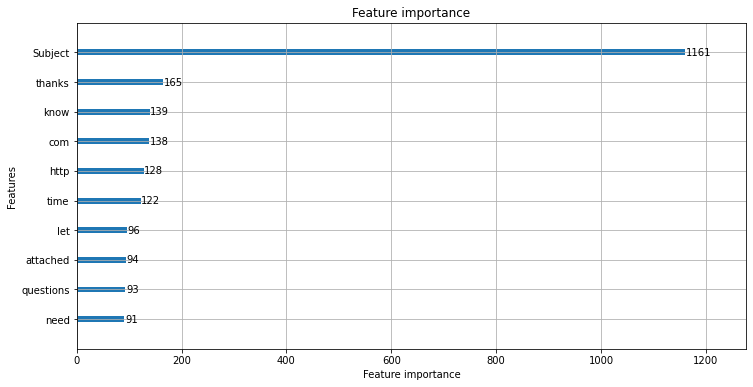

In [ ]:
import matplotlib.pyplot as plt
lgb.plot_importance(gbm, figsize=(12, 6), max_num_features=10)
plt.show()

In [ ]:
spam_rows = (df.label == '1')
spam_data = df[spam_rows]

count = 0
for i in spam_data['text']:
    count = count + i.count('subject')

print(count)

In [ ]:
legit_rows = (df.label == '0')
legit_data = df[legit_rows]

count = 0
for i in legit_data['text']:
    count = count + i.count('subject')

print(count)